# The quasi-deuteron model at low RG resolution

__A. J. Tropiano [tropiano.4@osu.edu]__<br/>
__January 24, 2022__

Using method from SRC paper to analyze the quasi-deuteron model and the Levinger constant in connection to GCF papers.

_Last update: April 27, 2022_

__To-do:__
* Repeating calculation of $L$ quite a bit - might want to make a function.
* Write/load data to `figures/quasideuteron/data` for slower functions.
* Update notes/markdown (brief).
* Add references (with links).
* Update function docstrings.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import time

In [ ]:
# Imports from A.T. codes
from scripts.densities import load_density
from scripts.figures import interpolate_matrix, xkcd_colors
from scripts.fourier_transform import hankel_transformation_k2r
from scripts.integration import gaussian_quadrature_mesh
from scripts.labels import (
    label_channel, label_kvnn, label_lambda, label_nucleus, label_ticks,
    replace_periods
)
from scripts.momentum_distributions import MomentumDistribution
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import convert_number_to_string, coupled_channel
from scripts.wave_function import wave_function

In [ ]:
# Update loading of VMC data

In [ ]:
# Update all calls to snmd, pmd, and dmd with
# momentum_distribution = MomentumDistribution(kvnn, kmax, kmid, ntot)
# followed with:

# get_single_nucleon_momentum_distribution(
#     nucleon, nucleus_name, density, channels, generator, lamb,
#     lambda_initial=None, kvnn_inv=None, delta_lambda=None,
#     contributions=False, interpolate=False)

# get_pair_momentum_distribution(
#             self, pair, nucleus_name, density, channels, generator, lamb,
#             lambda_initial=None, kvnn_inv=None, delta_lambda=None,
#             Q_equals_zero=False, contributions=False, interpolate=False)

# get_deuteron_momentum_distribution(
#             self, generator, lamb, lambda_initial=None, kvnn_inv=None,
#             delta_lambda=None, contributions=False, interpolate=False)

# Set-up

In [2]:
# Add this comment to the updated version
# Note, to get usetex=True to work, you need LaTeX, dvipng, and 
# Ghostscript>9.0. Might additionally cause issues if you don't have add-on 
# things (e.g., "cm-super: CM-Super family of fonts"). I got around this by 
# downloading TeX Live.
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [3]:
# Run this cell to customize matplotlib graphics
setup_rc_params(presentation=True)

In [4]:
# Save figures in the following directory
figure_directory = '../figures/quasideuteron'

# Load data from the following directories
exp_data_directory = '../data/exp' # Data from experiments
vmc_data_directory = '../data/vmc' # Momentum distributions from VMC

# Channels to include in calculations
channels = ['1S0', '3S1'] # S-waves only
channels_3s1 = ['3S1'] # 3S1-3D1 only
channels_pwaves = ['1S0', '3S1', '3P0', '1P1', '3P1'] # Some P-waves

# Use default momentum mesh
kmax, kmid, ntot = 15.0, 3.0, 120

# Default SRG \lambda value
lamb = 1.35
# Higher \lambda values
lambdas = [2, 3, 6]

# Nuclei from SLy4 densities
nuclei_sly4 = [
    ('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
    ('Ca48', 20, 28), ('Fe56', 26, 30), ('Pb208', 82, 126)
]

# Nuclei from Gogny densities
nuclei_gogny = [
    ('He4', 2, 2), ('Li7', 3, 4), ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8),
    ('Al27', 13, 14), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Ti48', 22, 26),
    ('Fe56', 26, 30), ('Cu63', 29, 34), ('Ag107', 47, 60), ('Sn118', 50, 68),
    ('Ce140', 58, 82), ('Ta181', 73, 108), ('Au197', 79, 118),
    ('Pb208', 82, 126), ('U238', 92, 146)
]

# The following nuclei are a subset of the Gogny densities
# For less cluttered figures
example_nuclei = [
    ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
    ('Fe56', 26, 30), ('Sn118', 50, 68), ('Pb208', 82, 126)
]

# Nuclei corresponding to experimental values of L
nuclei_exp = [
    ('Li7', 3, 4), ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8),
    ('Al27', 13, 14), ('Ca40', 20, 20), ('Ti48', 22, 26), ('Cu63', 29, 34),
    ('Ag107', 47, 60), ('Sn118', 50, 68), ('Ce140', 58, 82),
    ('Ta181', 73, 108), ('Pb208', 82, 126), ('U238', 92, 146)
]

# Default EDF will be Gogny
edf = 'Gogny'

# The Levinger constant

At high energy, the Levinger constant relates the photoabsorption cross sections of a nucleus to a deuteron. Experimental results suggest that the value is constant across the nuclear chart $L \approx 5.50 \pm 0.21$. In the GCF papers, they show that the Levinger constant can be related to the ratio of contacts. Furthermore, at high momentum

\begin{aligned}
\frac{ F_{pn}(A) }{ n_p(d) } \approx L \frac{NZ}{A},
\end{aligned}

where $F_{pn}(A)$ is the relative pair momentum distribution of nucleus $A$ (integrate out $Q$ dependence) and $n_p(d)$ is the proton momentum distribution in deuteron. They present a figure of this ratio and a table with the average value over the range $4$ to $5$ fm$^{-1}$ using VMC momentum distributions.

In our calculation,

\begin{aligned}
F_{pn}(A) \equiv 
    n_{pn}^A(q) \approx 
        |F^{\rm hi}(q)|^2 \int d^3Q \int d^3k \,|F^{\rm lo}(k)|^2
            \,\theta( k_F^p - |\frac{\mathbf{Q}}{2}+\mathbf{k}| )
            \,\theta( k_F^n - |\frac{\mathbf{Q}}{2}-\mathbf{k}| ),
\end{aligned}

and

\begin{aligned}
n_{p}(d) \approx&
    \int d^3K \int d^3k
        \,\delta U(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|)
        \,\delta U^{\dagger}(|\mathbf{q}-\frac{\mathbf{K}}{2}|,k)
            \,\theta( k_F^d - |\frac{\mathbf{K}}{2}+\mathbf{k}| )
            \,\theta( k_F^d - |\frac{\mathbf{K}}{2}-\mathbf{k}| ) \\
    \approx& |F^{\rm hi}(q)|^2 \int d^3K \int d^3k \,|F^{\rm lo}(k)|^2
            \,\theta( k_F^d - |\frac{\mathbf{K}}{2}+\mathbf{k}| )
            \,\theta( k_F^d - |\frac{\mathbf{K}}{2}-\mathbf{k}| ).
\end{aligned}

Therefore, the ratio is given by a mean-field quantity determined by integrals over the Heaviside step functions dependent on Fermi momenta. This is pretty much the same as the $a_2$ calculation.

### Ratio of $pn$ over $d$ distributions

In [5]:
def plot_levinger_ratio(
        nuclei, channels, kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
        edf='Gogny', wave_func=False, xlim=(0.0, 5.0), ylim=(0, 15)):
    """
    Plot ratios of the proton-neutron pair momentum distribution over the
    deuteron momentum distribution as a function of relative momentum q
    [fm^-1] (where the C.o.M. momentum Q is integrated out). The Levinger
    constant L is indicated by plateaus at high relative momentum scaled by
    NZ/A.
    
    Parameters
    ----------
    nuclei : list
        List that contains the details for various nuclei formatted as a
        tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    wave_func : bool, optional
        Option to use deuteron wave function from Hamiltonian associated with
        kvnn instead of HF+LDA deuteron momentum distribution n_d(q).
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    factor = 4*np.pi/(2*np.pi)**3
    
    if wave_func:
        
        potential = Potential(kvnn, '3S1', kmax, kmid, ntot)
        # Initial Hamiltonian to load deuteron wave function [MeV]
        H_initial = potential.load_hamiltonian()
        
        psi_unitless = wave_function(H_initial)
        
        # Momenta and weights of Hamiltonian
        q_array, q_weights = potential.load_mesh()
        ntot_q = ntot
        factor_array = 2/np.pi * q_weights * q_array**2
        
        # Deuteron momentum distribution
        n_d_array = ((psi_unitless[:ntot]**2 + psi_unitless[ntot:]**2)
                     / factor_array * (2*np.pi)**3 / (4*np.pi) * (2/np.pi))
        
        
    else:
        
        # Set relative momentum values over [0, 5] fm^-1
        q_min, q_max, q_step = 0.0, xlim[-1], 0.05
        q_array = np.arange(q_min, q_max + q_step, q_step)
        ntot_q = len(q_array)
    
        # Initialize deuteron momentum distribution class
        dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                              interp=True)
    
        # Get interpolated functions of deuteron momentum distribution
        # Take total only ignoring isolated I, \delta U, \delta U^2
        n_d_func, _, _, _ = dmd.n_lambda_interp()
    
        # Calculate deuteron momentum distribution
        n_d_array = n_d_func(q_array)
        
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights,
                                 indexing='ij')
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    

    # --- Loop over nuclei and calculate ratio --- #
    
    # Store ratios in dictionary with nucleus name as key
    d = {}
    for nucleus in nuclei:
        
        # Details of the nucleus
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N+Z
    
        # Try using interpolated pair momentum distribution first
        try:
    
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Need to generate files first
        except OSError:
    
            t0 = time.time()
            pmd.write_file(nucleus_name, 'pn', Z, N, edf)
            t1 = time.time()
            mins = (t1-t0)/60
            print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
            # Now get interpolated version
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
        # Calculate ratio and store in dictionary
        ratio_array = A/(N*Z) * n_pn_array / n_d_array
        d[nucleus_name] = ratio_array

    # Set-up average value of L
    L_mean = 5.5
    L_sig = 0.21
    
    # Convert L +/- L_sigma to arrays for errorbands
    L_upper_array = np.ones(ntot_q) * (L_mean + L_sig)
    L_lower_array = np.ones(ntot_q) * (L_mean - L_sig)
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$\frac{A}{NZ} \frac{ n_{pn}^A(q) }{ n_{p}^d(q) }$'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Add Levinger constant to figure (L = 5.5 +/- 0.21)
    ax.axhline(y=L_mean, label='L', color='xkcd:gray', alpha=0.6,
               linestyle='dashdot')
    ax.fill_between(q_array, y1=L_lower_array, y2=L_upper_array,
                    color='xkcd:gray', alpha=0.3)

    # Add ratios to plot
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'C12')
        nucleus_name = nucleus[0]
        ratio_array = d[nucleus_name]
        
        # Add nucleus to legend
        curve_label = label_nucleus(nucleus_name)
        
        # Set color
        curve_color = ff.xkcd_colors(i+1) # Skip black
        
        ax.plot(q_array, ratio_array, label=curve_label,
                linewidth=curve_width, color=curve_color)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [6]:
# AV18 with Gogny (not all in L plot)

kvnn = 6

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [7]:
# GT+ N2LO 1 fm

kvnn = 222

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [8]:
# GT+ N2LO 1.2 fm

kvnn = 224

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

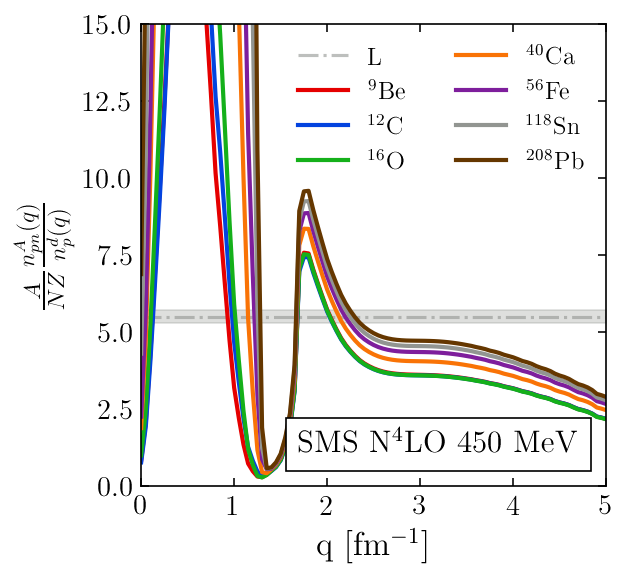

In [9]:
# SMS N4LO 450 MeV

kvnn = 111

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

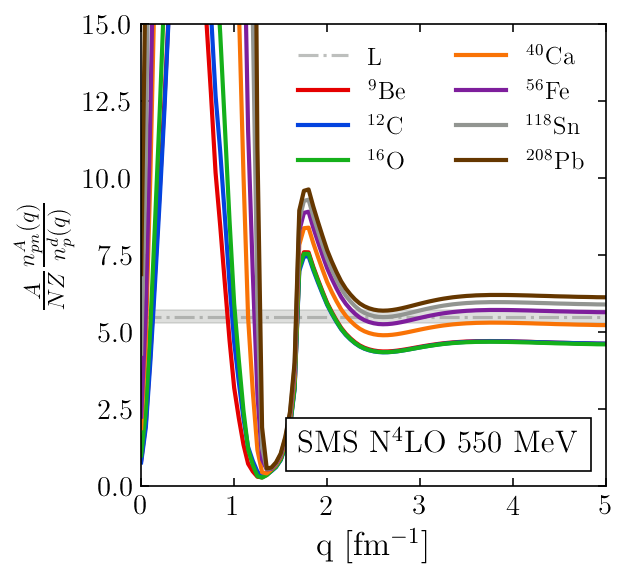

In [10]:
# SMS N4LO 550 MeV

kvnn = 113

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [11]:
# Nijmegen II

kvnn = 5

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [12]:
# CD-Bonn

kvnn = 7

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

### Table of average $L$ values

In [13]:
def levinger_constant_table(
        q_range, nuclei, channels, kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120, 
        edf='Gogny', print_over_qrange=False):
    """
    Compute the average L value associated with the ratio of the
    proton-neutron pair momentum distribution over the deuteron momentum
    distribution as a function of relative momentum q [fm^-1] (where the
    C.o.M. momentum Q is integrated out). Here we average over some relative
    momentum range (as in Weiss et al., https://arxiv.org/pdf/1503.07047.pdf).
    
    Parameters
    ----------
    q_range : 1-D ndarray
        Array of momentum values to average L over [fm^-1].
    nuclei : list
        List that contains the details for various nuclei formatted as a
        tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    print_over_qrange : bool, optional
        Option to print the pn/d ratio over the range of q values. This should
        help indicate which range of q values one should use when computing
        the avergage value of L. (We only need to do this for one nucleus -
        default is C12.)

    """
    
    # --- Set-up --- #
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only and ignore the isolated terms
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_range)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    

    # --- Loop over nuclei and print --- #
    
    # Print header
    print('-'*79)
    print(f'Computing L for kvnn = {kvnn} and EDF = {edf}')
    print(f'Averaging q from {min(q_range):.1f} to {max(q_range):.1f} fm^-1')
    
    for nucleus in nuclei:
        
        # Details of the nucleus
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N+Z
    
        # Try using interpolated pair momentum distribution first
        try:
    
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Need to generate files first
        except OSError:
    
            t0 = time.time()
            pmd.write_file(nucleus_name, 'pn', Z, N, edf)
            t1 = time.time()
            mins = (t1-t0)/60
            print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
            # Now get interpolated version
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1) 
    
        # Get mean value of ratio over momentum range and print results
        ratio_array = A/(N*Z) * n_pn_array / n_d_array
        L_avg = np.mean(ratio_array)
        
        # Print pn/d ratio w.r.t. q?
        if print_over_qrange and nucleus_name == 'C12':
            header = '\nq [fm^-1]\t\tpn/d\n'
            print(header)
            for iq, q in enumerate(q_range):
                print(q, ratio_array[iq])
            print('')
        
        print(f'Nucleus = {nucleus_name}, L = {L_avg:.2f}')

In [14]:
# AV18 with Gogny (default)

kvnn = 6

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [15]:
# AV18 but averaging at lower q values: 2.5 to 3.4 fm^-1

kvnn = 6

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [16]:
# GT+ N2LO 1 fm

kvnn = 222

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [17]:
# SMS N4LO 450 MeV

kvnn = 111

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [18]:
# SMS N4LO 550 MeV

kvnn = 113

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [19]:
# Nijmegen II

kvnn = 5

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [20]:
# CD-Bonn

kvnn = 7

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

### Compare average $L$ values to experiment

In [21]:
def plot_levinger_constant_exp(
        q_range_1, q_range_2, nuclei, channels, kvnn, lamb, kmax=15.0,
        kmid=3.0, ntot=120, edf='Gogny', xlim=(5e0, 3e2), ylim=(0.0, 10.0)):
    """
    Plot the average Levinger constant values L associated with the ratio of
    pn/d momentum distributions with respect to mass number A. Compare to
    experimental data. Add errorbars to our predictions for L based on the
    upper/lower values of pn/d over two different q_range intervals.
    
    Parameters
    ----------
    q_range_1 : 1-D ndarray
        First array of momentum values to average L over [fm^-1].
    q_range_2 : 1-D ndarray
        Second array of momentum values to average L over [fm^-1].
    nuclei : list
        List that contains the details for various nuclei formatted as a
        tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Get number of nuclei
    ntot_A = len(nuclei)
    
    # Initialize array to store A
    A_array = np.zeros(ntot_A)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Ignore the 1, \delta U, and \delta U^2 isolated contributions
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    
    # Add L_array to dictionary
    d = {}
    for i, q_range in enumerate([q_range_1, q_range_2]):
        
        # Initialize array to store L (temporarily)
        L_array_temp = np.zeros(ntot_A)
    
        # Get number of q points
        ntot_q = len(q_range)
    
        # Set-up meshes corresponding to q_i and Q_j
        q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
        # Set-up mesh for Q integration
        _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights,
                                 indexing='ij')
        factor = 4*np.pi/(2*np.pi)**3
    
        # Calculate deuteron momentum distribution
        n_d_array = n_d_func(q_range)

            
        # --- Loop over nuclei and calculate --- #
        for j, nucleus in enumerate(nuclei):
        
            # Details of the nucleus
            nucleus_name = nucleus[0]
            Z = nucleus[1]
            N = nucleus[2]
            A = N+Z
            
            # Add A value to array
            A_array[j] = A
    
            # Try using interpolated pair momentum distribution first
            try:
    
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn',
                                                         Z, N, edf)

            # Need to generate files first
            except OSError:
    
                t0 = time.time()
                pmd.write_file(nucleus_name, 'pn', Z, N, edf)
                t1 = time.time()
                mins = (t1-t0)/60
                print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
                # Now get interpolated version
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn',
                                                         Z, N, edf)

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
            # Factor of 2 for pn+np
            n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh)

            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
            # Get mean value of ratio over q_range
            ratio_array = A/(N*Z) * n_pn_array / n_d_array
            L_array_temp[j] = np.mean(ratio_array)
            
            # Add L values to dictionary
            d[i] = L_array_temp
            
    # Take average of L_array's as central value and use minimum and maximum
    # as errorbars
    L_full = np.array( [ d[0], d[1] ] )
    L_array = np.mean(L_full, axis=0) # Central values of L w.r.t. A
    L_upper_array = np.amax(L_full, axis=0) # Upper limits of L w.r.t. A
    L_lower_array = np.amin(L_full, axis=0) # Lower limits of L w.r.t. A
        
    # Get array of errors (deviations from central values w.r.t. A)
    L_errors_array = ( L_upper_array - L_lower_array ) / 2

        
    # --- Experimental values --- #
    
    data_ahr = np.loadtxt(
        exp_data_directory + '/' + \
        'Ahrens_L_Li7_Be9_C12_O16_Al27_Ca40.txt'
        )
    A_ahr_array = data_ahr[:, 0]
    L_ahr_array = data_ahr[:, 1]
    L_errors_ahr_array = np.array([ data_ahr[:, 2], data_ahr[:, 3] ])
    
    data_sti = np.loadtxt(
        exp_data_directory + '/' + \
        'Stibunov_L_C12_Al27_Ti48_Cu63_Ag107_Sn118_Pb208.txt'
        )
    A_sti_array = data_sti[:, 0]
    L_sti_array = data_sti[:, 1]
    L_errors_sti_array = np.array([ data_sti[:, 2], data_sti[:, 3] ])
    
    data_lep = np.loadtxt(
        exp_data_directory + '/' + \
        'Lepretre_L_Sn118_Ce140_Ta181_Pb208_U238.txt'
        )
    A_lep_array = data_lep[:, 0]
    L_lep_array = data_lep[:, 1]
    L_errors_lep_array = np.array([ data_lep[:, 2], data_lep[:, 3] ])

    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = 'L'
    y_label_size = 16

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set log-scale on x-axis
    ax.set_xscale('log')
    
    # Experimental values
    ax.errorbar(A_ahr_array, L_ahr_array, yerr=L_errors_ahr_array,
                color='xkcd:red', marker='^', linestyle='', markersize=6,
                label='Ahrens')
    ax.errorbar(A_sti_array, L_sti_array, yerr=L_errors_sti_array,
                color='xkcd:green', marker='d', linestyle='', markersize=6,
                label='Stibunov')
    ax.errorbar(A_lep_array, L_lep_array, yerr=L_errors_lep_array,
                color='xkcd:blue', marker='s', linestyle='', markersize=6,
                label='Lepretre')
    
    # Set curve label as potential
    curve_label = f'{label_kvnn(kvnn)}'

    # Plot all your values at the same time (same markers and color)
    # Offset A by a bit so you can compare results
    ax.errorbar(A_array, L_array, yerr=L_errors_array, color='xkcd:black',
                marker='o', linestyle='', markersize=4, label=curve_label)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

In [22]:
# Levinger values comparing default case (AV18 + Gogny) to experiment

kvnn = 6

# Average over two different ranges of q values
q_min_1, q_max_1, q_step_1 = 4.0, 5.0, 0.1
q_range_1 = np.arange(q_min_1, q_max_1 + q_step_1, q_step_1)
q_min_2, q_max_2, q_step_2 = 2.5, 3.4, 0.05
q_range_2 = np.arange(q_min_2, q_max_2 + q_step_2, q_step_2)

f, ax = plot_levinger_constant_exp(q_range_1, q_range_2, nuclei_exp, channels,
                                   kvnn, lamb, kmax, kmid, ntot, edf)

# Add legend
legend_size = 13
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set file name
file_name = 'levinger_constant_exp'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

### Compare average $L$ values between different interactions

In [23]:
def print_d_state_prob(kvnn, kmax=15.0, kmid=3.0, ntot=120):
    """
    Print the S- and D-state probability of deuteron for the given potential.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
        
    """
    
    # 3S1-3D1 channel for deuteron
    channel = '3S1'
    
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    # Get Hamiltonian
    H_matrix = potential.load_hamiltonian()
    
    # Get deuteron wave function (unitless)
    psi_unitless = wave_function(H_matrix)

    # Compute S- and D-state probabilities
    s_state_prob = np.sum( psi_unitless[:ntot]**2 )
    d_state_prob = np.sum( psi_unitless[ntot:]**2 )
    
    # Print
    print(f'kvnn = {kvnn}')
    print(f'S-state probability = {s_state_prob:.4f}')
    print(f'D-state probability = {d_state_prob:.4f}\n')

In [24]:
def plot_levinger_constant_vary_kvnn(
        q_range, nuclei, channels, kvnns, lamb, kmax=15.0, kid=3.0, ntot=120,
        edf='Gogny', xlim=(5e0, 3e2), ylim=(0.0, 10.0), sd_prob=False):
    """
    Plot the average Levinger constant values L associated with the ratio of
    pn/d momentum distributions with respect to mass number A. Compare to
    experimental data.
    
    Parameters
    ----------
    q_range : 1-D ndarray
        Array of momentum values to average L over [fm^-1].
    nuclei : list
        List that contains the details for various nuclei formatted as a
        tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnns : list
        List of kvnn numbers which specify the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
    sd_prob : bool, optional
        Option to print S- and D-state probabilities of deuteron for each
        potential.
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Get number of nuclei
    ntot_A = len(nuclei)
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Store arrays of L in dictionary with kvnn as the key
    d = {}
    
            
    # --- Loop over kvnn, nuclei and calculate --- #
    for kvnn in kvnns:
        
        d[kvnn] = {}
        
        # Print S- and D-state probabilities of deuteron?
        if sd_prob:
            print_d_state_prob(kvnn, kmax, kmid, ntot)
        
        # Initialize arrays for A and L
        A_array = np.zeros(ntot_A)
        L_array = np.zeros(ntot_A)
        
        # Initialize deuteron momentum distribution class
        dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                              interp=True)
    
        # Get interpolated functions of deuteron momentum distribution
        # Ignore the 1, \delta U, and \delta U^2 isolated contributions
        n_d_func, _, _, _ = dmd.n_lambda_interp()
    
        # Calculate deuteron momentum distribution
        n_d_array = n_d_func(q_range)
    
        # Initialize pair momentum distribution class
        pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid,
                                          ntot)
        
        for j, nucleus in enumerate(nuclei):
        
            # Details of the nucleus
            nucleus_name = nucleus[0]
            Z = nucleus[1]
            N = nucleus[2]
            A = N+Z
            
            # Add A value to array
            A_array[j] = A
    
            # Try using interpolated pair momentum distribution first
            try:
    
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn',
                                                         Z, N, edf)

            # Need to generate files first
            except OSError:
    
                t0 = time.time()
                pmd.write_file(nucleus_name, 'pn', Z, N, edf)
                t1 = time.time()
                mins = (t1-t0)/60
                print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
                # Now get interpolated version
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn',
                                                         Z, N, edf)

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
            # Factor of 2 for pn+np
            n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh)

            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
            # Get mean value of ratio over q_range
            ratio_array = A/(N*Z) * n_pn_array / n_d_array
            L_array[j] = np.mean(ratio_array)
            
        # Add to dictionary
        d[kvnn]['A_array'] = A_array
        d[kvnn]['L_array'] = L_array
        
        
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = 'L'
    y_label_size = 16

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set log-scale on x-axis
    ax.set_xscale('log')

    # Loop over kvnns
    for i, kvnn in enumerate(kvnns):
    
        # Curve label should be potential
        curve_label = label_kvnn(kvnn)
        
        # Set marker color
        marker_color = ff.xkcd_colors(i)
        
#         ax.plot(d[kvnn]['A_array'], d[kvnn]['L_array'], color=marker_color,
#                 marker='.', markersize=8, linestyle='', label=curve_label)
        
        # Set marker
        if i == 0:
            marker_type = 's'
        elif i == 1:
            marker_type = 'o'
        elif i == 2:
            marker_type = 'd'
        elif i == 3:
            marker_type = '^'
        elif i == 4:
            marker_type = 'v'
        elif i == 5:
            marker_type = 'p'

        ax.plot(
            d[kvnn]['A_array'], d[kvnn]['L_array'], color=marker_color,
            linestyle='', label=curve_label, marker=marker_type, markersize=5
        )

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

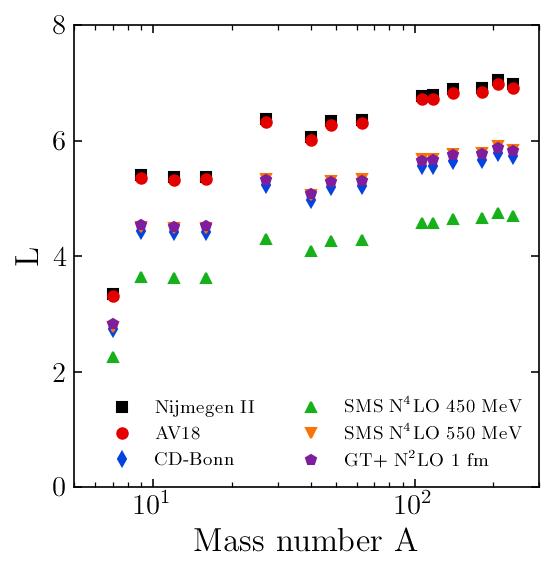

In [25]:
# Levinger values comparing Gogny with Nijmegen II, AV18, CD-Bonn, SMS N4LO
# 450 MeV and 550 MeV, and GT+ N2LO 1 fm

kvnns = [5, 6, 7, 111, 113, 222]
edf = 'Gogny'

# Set relative momentum values over a lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

ylim = (0, 8)

f, ax = plot_levinger_constant_vary_kvnn(
    q_range, nuclei_exp, channels, kvnns, lamb, kmax, kmid, ntot, edf, 
    ylim=ylim, sd_prob=False
)

# Add legend
# legend_size = 12
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#           fontsize=legend_size)
legend_size = 9
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set file name
file_name = 'levinger_constant'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnns'
for ikvnn in kvnns:
    file_name += f'_{ikvnn}'
file_name += f'_lamb_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

# Connecting hard and soft potentials with the SRG

In [26]:
def deuteron_scale_dependence(
        kvnn_soft, kvnn_hard, lambda_array, kmax=15.0, kmid=3.0, ntot=120,
        xlim=(0, 6), ylim=(1e-6, 1e3)):
    """
    Evolve a hard potential to roughly match a softer potential. Compare
    deuteron momentum distributions to get the correct matching \lambda.
    
    Parameters
    ----------
    kvnn_soft : int
        This number specifies the softer potential.
    kvnn_hard : int
        This number specifies the harder potential.
    lambda_array : 1-D ndarray
        \lambda evolution values [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    potential_soft = Potential(kvnn_soft, '3S1', kmax, kmid, ntot)
    
    # The momentum mesh should be the same between both potentials
    q_array, q_weights = potential_soft.load_mesh()
    # Units of factor_array are fm^-3/2
    factor_array = np.concatenate( (np.sqrt(2/np.pi * q_weights) * q_array,
                                    np.sqrt(2/np.pi * q_weights) * q_array ) )

    # Get Hamiltonian for soft potential
    H_soft_init = potential_soft.load_hamiltonian()
    
    # Get deuteron wave function
    wf_soft_unitless = wave_function(H_soft_init)
    wf_soft_init = wf_soft_unitless / factor_array # Units fm^3/2
    
    # Deuteron momentum distribution
    n_d_soft_init = wf_soft_init[:ntot]**2 + wf_soft_init[ntot:]**2 # fm^3
    
    potential_hard = Potential(kvnn_hard, '3S1', kmax, kmid, ntot)

    # Get Hamiltonian for hard potential
    H_hard_init = potential_hard.load_hamiltonian()
    
    # Get deuteron wave function
    wf_hard_unitless = wave_function(H_hard_init)
    wf_hard_init = wf_hard_unitless / factor_array # Units fm^3/2
    
    # Deuteron momentum distribution
    n_d_hard_init = wf_hard_init[:ntot]**2 + wf_hard_init[ntot:]**2
    
    # Loop over \lambda values and store momentum distributions in dictionary
    d = {}
    for lamb in lambda_array:
        
        # Get evolved Hamiltonian for hard potential
        H_hard_srg = potential_hard.load_hamiltonian('srg', 'Wegner', lamb)

        # Get SRG transformation connecting the two potentials
        U_matrix = get_transformation(H_hard_init, H_hard_srg)

        # SRG-evolved deuteron wave function in units fm^3/2
        wf_hard_srg = (U_matrix @ wf_hard_unitless) / factor_array
    
        # SRG-evolved deuteron momentum distribution
        # Key is \lambda value
        d[lamb] = wf_hard_srg[:ntot]**2 + wf_hard_srg[ntot:]**2
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = '$n_d(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set y-axis to log scale
    ax.set_yscale('log')

    # Hard potential first
#     ax.plot(q_array, n_d_hard_init, label=label_kvnn(kvnn_hard),
#             linewidth=curve_width, linestyle='solid', color='xkcd:red')
    ax.plot(q_array, n_d_hard_init, label=label_kvnn(kvnn_hard),
            linewidth=curve_width, linestyle='solid', color='xkcd:blue')
#     ax.plot(q_array, n_d_hard_init, label=label_kvnn(kvnn_hard),
#             linewidth=curve_width, linestyle='solid', color='xkcd:black')
    
    # Soft potential second
#     ax.plot(q_array, n_d_soft_init, label=label_kvnn(kvnn_soft),
#             linewidth=curve_width, linestyle='solid', color='xkcd:black')
    ax.plot(q_array, n_d_soft_init, label=label_kvnn(kvnn_soft),
            linewidth=curve_width, linestyle='solid', color='xkcd:red')
    
    # Loop over \lambda values and add to plot
    for i, lamb in enumerate(lambda_array):
        
        # curve_color = ff.xkcd_colors(i+2)
        curve_alpha = 0.8 - i*0.2
        # curve_alpha = 1.0 - i*0.25
#         ax.plot(
#             q_array, d[lamb], label=label_lambda(lamb),
#             color='xkcd:red', alpha=curve_alpha, linewidth=curve_width,
#             linestyle='dashed'
#             )
        ax.plot(
            q_array, d[lamb], label=label_lambda(lamb),
            color='xkcd:blue', alpha=curve_alpha, linewidth=curve_width,
            linestyle='dashed'
            )

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [27]:
def deuteron_scale_dependence_r(
        kvnn_soft, kvnn_hard, lambda_array, kmax=15.0, kmid=3.0, ntot=120,
        xlim=(0, 5), ylim=(-0.2, 0.5)):
    """
    Evolve a hard potential to roughly match a softer potential. Compare
    deuteron wave functions in coordinate space to get the correct \lambda'.
    
    Parameters
    ----------
    kvnn_soft : int
        This number specifies the softer potential.
    kvnn_hard : int
        This number specifies the harder potential.
    lambda_array : 1-D ndarray
        \lambda evolution values [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm].
    ylim : tuple, optional
        Limits of y-axis [fm^-3/2].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    potential_soft = Potential(kvnn_soft, channel, kmax, kmid, ntot)
    potential_hard = Potential(kvnn_hard, channel, kmax, kmid, ntot)
    
    # The momentum mesh should be the same between both potentials
    q_array, q_weights = potential_soft.load_mesh()
    # Units of factor_array are fm^-3/2
    factor_array = np.concatenate( (np.sqrt(2/np.pi * q_weights) * q_array,
                                    np.sqrt(2/np.pi * q_weights) * q_array ) )
    
    # Load Hankel transformations
    hank_trans_3S1 = hankel_transformation_k2r('3S1', q_array, q_weights,
                                               r_array)
    hank_trans_3D1 = hankel_transformation_k2r('3D1', q_array, q_weights,
                                               r_array)
    
    # Initialize dictionary
    d = {}
    d['3S1'] = {}
    d['3D1'] = {}

    # Get Hamiltonian for soft potential
    H_soft_init = potential_soft.load_hamiltonian()
    
    # Get deuteron wave function in k-space
    wf_soft_unitless = wave_function(H_soft_init)
    wf_soft_init = wf_soft_unitless / factor_array # Units fm^3/2
    
    # Fourier transform to coordinate space (units are fm^-3/2)
    d['3S1']['soft'] = hank_trans_3S1 @ wf_soft_init[:ntot]
    d['3D1']['soft'] = hank_trans_3D1 @ wf_soft_init[ntot:]

    # Get Hamiltonian for hard potential
    H_hard_init = potential_hard.load_hamiltonian()
    
    # Get deuteron wave function
    wf_hard_unitless = wave_function(H_hard_init)
    wf_hard_init = wf_hard_unitless / factor_array # Units fm^3/2
    
    # Fourier transform to coordinate space (units are fm^-3/2)
    d['3S1']['hard'] = hank_trans_3S1 @ wf_hard_init[:ntot]
    d['3D1']['hard'] = hank_trans_3D1 @ wf_hard_init[ntot:]
    
    # Loop over \lambda values and store momentum distributions in dictionary
    for lamb in lambda_array:
        
        # Get evolved Hamiltonian for hard potential
        H_hard_srg = potential_hard.load_hamiltonian('srg', 'Wegner', lamb)

        # Get SRG transformation connecting the two potentials
        U_matrix = get_transformation(H_hard_init, H_hard_srg)

        # SRG-evolved deuteron wave function in units fm^3/2
        wf_hard_srg = (U_matrix @ wf_hard_unitless) / factor_array
    
        # Fourier transform to coordinate space (units are fm^-3/2)
        d['3S1'][lamb] = hank_trans_3S1 @ wf_hard_srg[:ntot]
        d['3D1'][lamb] = hank_trans_3D1 @ wf_hard_srg[ntot:]
        
    # Manually fix the sign
    for key in d['3S1']: # Will affect 3D1 in the same way
        if d['3S1'][key][30] < 0.0: # ~ \psi_d(1 fm^-1) < 0
            d['3S1'][key] *= -1
            d['3D1'][key] *= -1
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'r [fm]'
    x_label_size = 16
    y_label = r'$\psi_d(r)$' + ' [fm' + r'$^{-3/2}$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Add horizontal line at psi_d = 0
    ax.axhline(0.0, color='gray', alpha=0.4)

    # Hard potential first
#     ax.plot(
#         r_array, d['3S1']['hard'], linestyle='solid', color='xkcd:red',
#         label=label_kvnn(kvnn_hard), linewidth=curve_width,
#     )
#     ax.plot(r_array, d['3D1']['hard'], linestyle='dashed', color='xkcd:red',
#             linewidth=curve_width)
    ax.plot(
        r_array, d['3S1']['hard'], linestyle='solid', color='xkcd:blue',
        label=label_kvnn(kvnn_hard), linewidth=curve_width,
    )
    ax.plot(r_array, d['3D1']['hard'], linestyle='dashed', color='xkcd:blue',
            linewidth=curve_width)
    
    # Soft potential second
#     ax.plot(
#         r_array, d['3S1']['soft'], linestyle='solid', color='xkcd:black',
#         label=label_kvnn(kvnn_soft), linewidth=curve_width,
#     )
#     ax.plot(r_array, d['3D1']['soft'], linestyle='dashed', color='xkcd:black',
#             linewidth=curve_width)
    ax.plot(
        r_array, d['3S1']['soft'], linestyle='solid', color='xkcd:red',
        label=label_kvnn(kvnn_soft), linewidth=curve_width,
    )
    ax.plot(r_array, d['3D1']['soft'], linestyle='dashed', color='xkcd:red',
            linewidth=curve_width)
    
    # Loop over \lambda values and add to plot
    for i, lamb in enumerate(lambda_array):
        
        # curve_color = ff.xkcd_colors(i+2)
        curve_alpha = 0.8 - i*0.2
#         ax.plot(
#             r_array, d['3S1'][lamb], linewidth=curve_width, color='xkcd:red',
#             alpha=curve_alpha, linestyle='solid',
#             label=label_lambda(lamb)
#         )
#         ax.plot(
#             r_array, d['3D1'][lamb], linewidth=curve_width, color='xkcd:red',
#             alpha=curve_alpha, linestyle='dashed'
#         )
        ax.plot(
            r_array, d['3S1'][lamb], linewidth=curve_width, color='xkcd:blue',
            alpha=curve_alpha, linestyle='solid',
            label=label_lambda(lamb)
        )
        ax.plot(
            r_array, d['3D1'][lamb], linewidth=curve_width, color='xkcd:blue',
            alpha=curve_alpha, linestyle='dashed'
        )

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

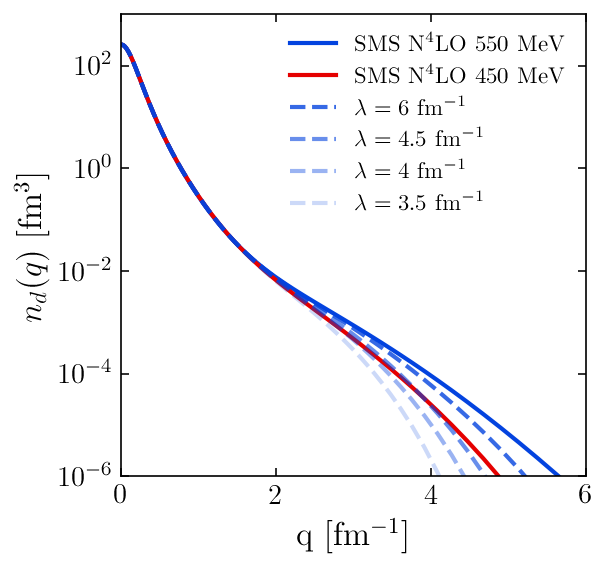

In [28]:
# Compare the SMS N4LO 550 MeV and 450 MeV potentials

kvnn_soft = 111 # 450 MeV
kvnn_hard = 113 # 550 MeV

# \lambda values
# lambda_array = np.array( [6.0, 4.5, 4.0, 3.0] )
lambda_array = np.array( [6.0, 4.5, 4.0, 3.5] )

f, ax = deuteron_scale_dependence(kvnn_soft, kvnn_hard, lambda_array, kmax,
                                  kmid, ntot)

# Add legend
legend_size = 11
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'deuteron_scale_dependence' + \
    f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

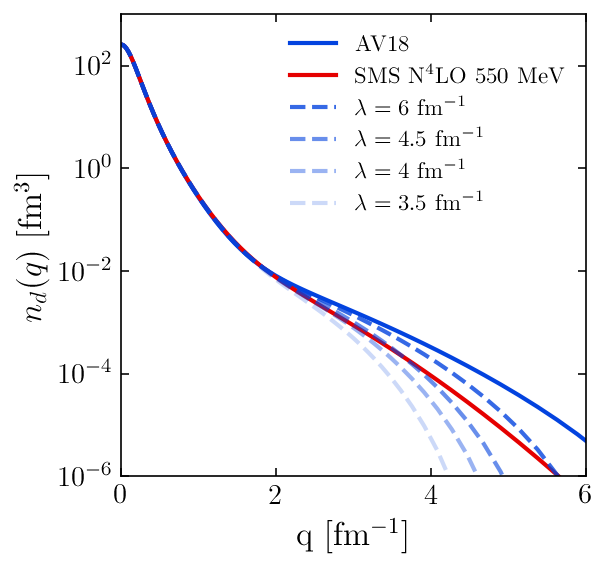

In [29]:
# Compare AV18 and SMS N4LO 550 MeV potentials

kvnn_soft = 113 # SMS N4LO 550 MeV
kvnn_hard = 6 # AV18

# \lambda values
# lambda_array = np.array( [6.0, 4.5, 4.0, 3.0] )
lambda_array = np.array( [6.0, 4.5, 4.0, 3.5] )

f, ax = deuteron_scale_dependence(kvnn_soft, kvnn_hard, lambda_array, kmax,
                                  kmid, ntot)

# Add legend
legend_size = 11
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'deuteron_scale_dependence' + \
    f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

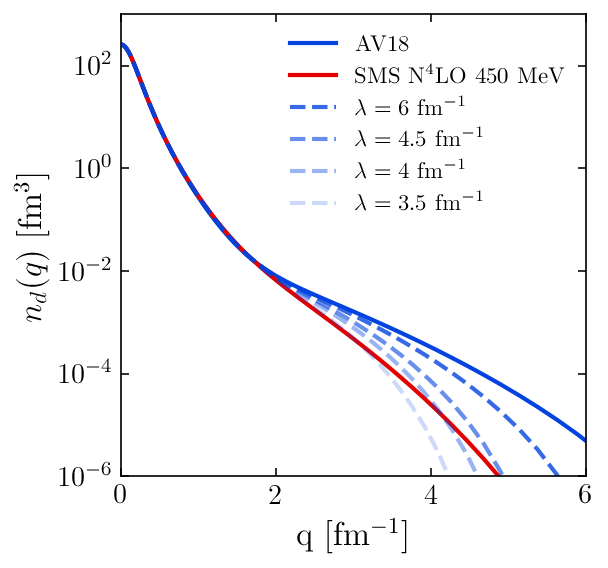

In [30]:
# Compare AV18 and SMS N4LO 450 MeV potentials

kvnn_soft = 111 # SMS N4LO 450 MeV
kvnn_hard = 6 # AV18

# \lambda values
# lambda_array = np.array( [6.0, 4.5, 4.0, 3.0] )
lambda_array = np.array( [6.0, 4.5, 4.0, 3.5] )

f, ax = deuteron_scale_dependence(kvnn_soft, kvnn_hard, lambda_array, kmax,
                                  kmid, ntot)

# Add legend
legend_size = 11
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'deuteron_scale_dependence' + \
    f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [31]:
# Compare AV18 and GT+ 1 fm potentials

kvnn_soft = 222 # GT+ 1 fm
kvnn_hard = 6 # AV18

# \lambda values
# lambda_array = np.array( [6.0, 4.5, 4.0, 3.0] )
lambda_array = np.array( [6.0, 4.5, 4.0, 3.5] )

f, ax = deuteron_scale_dependence(kvnn_soft, kvnn_hard, lambda_array, kmax,
                                  kmid, ntot)

# Add legend
legend_size = 11
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'deuteron_scale_dependence' + \
    f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

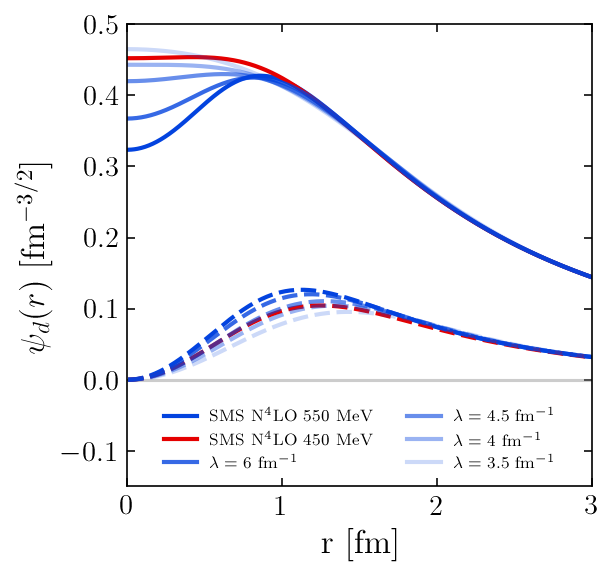

In [32]:
# Compare the SMS N4LO 550 MeV and 450 MeV potentials (in r-space)

kvnn_soft = 111 # 450 MeV
kvnn_hard = 113 # 550 MeV

# \lambda values
# lambda_array = np.array( [6.0, 4.5, 4.0, 3.0] )
lambda_array = np.array( [6.0, 4.5, 4.0, 3.5] )

xlim = (0, 3)
ylim = (-0.15, 0.5)

f, ax = deuteron_scale_dependence_r(kvnn_soft, kvnn_hard, lambda_array, kmax,
                                    kmid, ntot, xlim=xlim, ylim=ylim)

# Add legend
legend_size = 8
legend_location = 'lower center'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set file name
file_name = 'deuteron_scale_dependence_r' + \
    f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

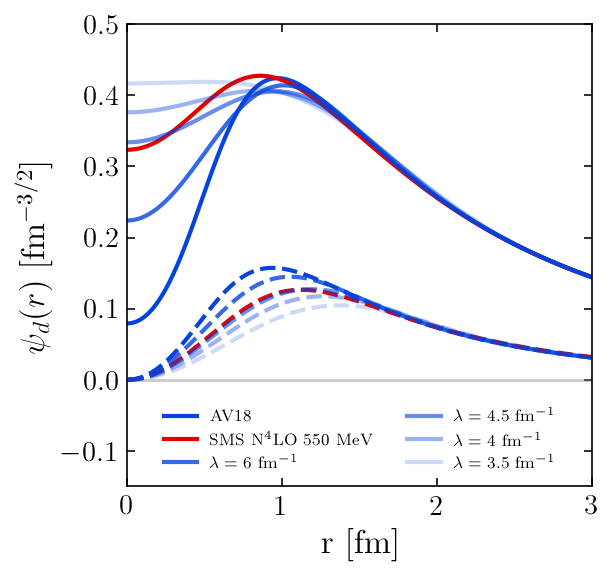

In [33]:
# Compare the AV18 and SMS N4LO 550 MeV potentials (in r-space)

kvnn_soft = 113 # 550 MeV
kvnn_hard = 6 # AV18 MeV

# \lambda values
# lambda_array = np.array( [6.0, 4.5, 4.0, 3.0] )
lambda_array = np.array( [6.0, 4.5, 4.0, 3.5] )

xlim = (0, 3)
ylim = (-0.15, 0.5)

f, ax = deuteron_scale_dependence_r(kvnn_soft, kvnn_hard, lambda_array, kmax,
                                    kmid, ntot, xlim, ylim)

# Add legend
legend_size = 8
legend_location = 'lower center'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set file name
file_name = 'deuteron_scale_dependence_r' + \
    f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [34]:
# Compare the AV18 and GT+ N2LO 1 fm potentials (in r-space)

kvnn_soft = 222 # GT+ N2LO 1 fm
kvnn_hard = 6 # AV18

# \lambda values
lambda_array = np.array( [6.0, 5.0, 4.5, 4.0] )

xlim = (0, 3)
ylim = (-0.15, 0.5)

f, ax = deuteron_scale_dependence_r(kvnn_soft, kvnn_hard, lambda_array, kmax,
                                    kmid, ntot, xlim, ylim)

# Add legend
legend_size = 8
legend_location = 'lower center'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set file name
file_name = 'deuteron_scale_dependence_r' + \
    f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

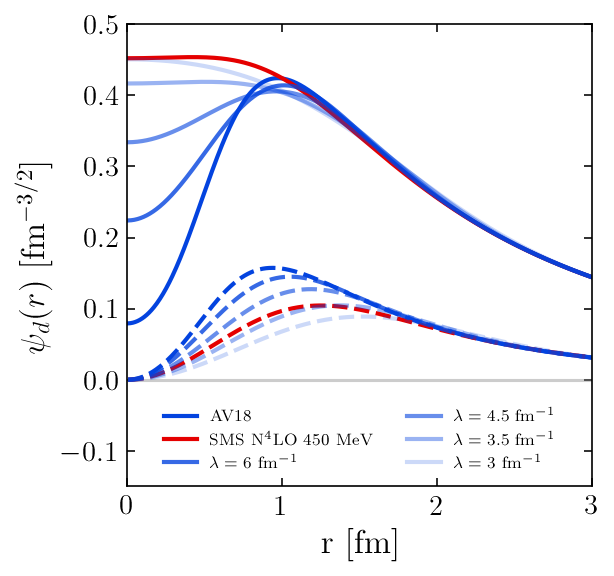

In [35]:
# Compare the AV18 and SMS N4LO 450 MeV potentials (in r-space)

kvnn_soft = 111 # 450 MeV
kvnn_hard = 6 # AV18 MeV

# \lambda values
lambda_array = np.array( [6.0, 4.5, 3.5, 3.0] )

xlim = (0, 3)
ylim = (-0.15, 0.5)

f, ax = deuteron_scale_dependence_r(kvnn_soft, kvnn_hard, lambda_array, kmax,
                                    kmid, ntot, xlim, ylim)

# Add legend
legend_size = 8
legend_location = 'lower center'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set file name
file_name = 'deuteron_scale_dependence_r' + \
    f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

### Inverse-SRG-evolution

In [36]:
def inverse_srg(kvnn_soft, kvnn_hard, channel, lambda_array, kmax=15.0,
                kmid=3.0, ntot=120, hamiltonian=False):
    """
    Apply inverse SRG transformations to a soft potential to make it harder.
    
    Parameters
    ----------
    kvnn_soft : int
        This number specifies the softer potential.
    kvnn_hard : int
        This number specifies the harder potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    lambda_array : 1-D ndarray
        SRG \lambda evolution values [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    hamiltonian : bool, optional
        Option to return Hamiltonians (in MeV) instead of potentials.
    
    Returns
    -------
    k_array : 1-D ndarray
        Momentum values [fm^-1] corresponding to the potentials.
    V_list : list
        List of potentials [fm] which are 2-D ndarrays.
        
    """
    
    potential_soft = Potential(kvnn_soft, channel, kmax, kmid, ntot)
    potential_hard = Potential(kvnn_hard, channel, kmax, kmid, ntot)
    
    # Get momenta and weights
    k_array, k_weights = potential_soft.load_mesh()
    
    # Get kinetic energy to subtract out (doesn't matter which kvnn)
    T_matrix = potential_soft.load_kinetic_energy()

    # Get initial Hamiltonians for the soft and hard potentials (MeV)
    H_soft_initial = potential_soft.load_hamiltonian()
    H_hard_initial = potential_hard.load_hamiltonian()
    
    # Initialize list of potentials
    if hamiltonian:
        
        # Do Hamiltonians in MeV
        V_list = [H_hard_initial, H_soft_initial]
    
    else:

        # Subtract out the kinetic energy (units are MeV)
        V_hard_initial_MeV = H_hard_initial - T_matrix
        V_soft_initial_MeV = H_soft_initial - T_matrix
        
        # Convert potentials to fm
        V_soft_initial = potential_soft.convert_V_to_fm(V_soft_initial_MeV)
        V_hard_initial = potential_hard.convert_V_to_fm(V_hard_initial_MeV)
        
        # Do potentials in fm
        V_list = [V_hard_initial, V_soft_initial]
    
    # Loop over \lambda values
    for lamb in lambda_array:

        # Get the SRG-evolved hard potential (MeV)
        H_hard_evolved = potential_hard.load_hamiltonian('srg', 'Wegner',
                                                         lamb)

        # Construct SRG transformation (unitless)
        U_matrix = get_transformation(H_hard_initial, H_hard_evolved)
    
        # Apply inverse transformations to soft potential
        H_soft_evolved = U_matrix.T @ H_soft_initial @ U_matrix
        
        # Append Hamiltonian [MeV] to list
        if hamiltonian:
        
            V_list.append(H_soft_evolved)
            
        # Append potential [fm] to list
        else:
            
            # Subtract out the kinetic energy (units are MeV)
            V_soft_evolved_MeV = H_soft_evolved - T_matrix
            
            # Convert potential to fm
            V_soft_evolved = potential_soft.convert_V_to_fm(
                V_soft_evolved_MeV)
            
            V_list.append(V_soft_evolved)

    # Return list of potentials (or Hamiltonians)
    return k_array, V_list

In [37]:
def deuteron_scale_dependence_inv_r(
        kvnn_soft, kvnn_hard, lambda_array, kmax=15.0, kmid=3.0, ntot=120, 
        xlim=(0, 5), ylim=(-0.2, 0.5)):
    """
    Plots the deuteron wave function [fm^-3/2] with respect to relative 
    distance [fm] for a hard and soft Hamiltonian. Also shown are deuteron 
    wave functions from applying inverse-SRG transformations of the hard
    potential onto the soft one to several \lambda values.
    
    Parameters
    ----------
    kvnn_soft : int
        This number specifies the softer potential.
    kvnn_hard : int
        This number specifies the harder potential.
    lambda_array : 1-D ndarray
        SRG \lambda evolution values [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'r [fm]'
    x_label_size = 16
    y_label = r'$\psi_d(r)$' + ' [fm' + r'$^{-3/2}$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Add horizontal line at psi_d = 0
    ax.axhline(0.0, color='gray', alpha=0.4)
    
    # Hamiltonians ordered as follows: H_hard, H_soft, H_soft(\lambda_1), ...
    _, H_list = inverse_srg(kvnn_soft, kvnn_hard, channel, lambda_array, kmax,
                         kmid, ntot, hamiltonian=True)
    
    # Get momenta and weights (doesn't matter which kvnn or channel)
    potential = Potential(kvnn_soft, channel, kmax, kmid, ntot)
    q_array, q_weights = potential.load_mesh()
    # Units of factor_array are fm^-3/2
    factor_array = np.concatenate( (np.sqrt(2/np.pi * q_weights) * q_array,
                                    np.sqrt(2/np.pi * q_weights) * q_array ) )
    
    # Load Hankel transformations
    hank_trans_3S1 = hankel_transformation_k2r('3S1', q_array, q_weights,
                                               r_array)
    hank_trans_3D1 = hankel_transformation_k2r('3D1', q_array, q_weights,
                                               r_array)
    
    # Loop over Hamiltonians
    for i, H_matrix in enumerate(H_list):
        
        # Momentum space wave function # fm^3/2
        psi_k_unitless = wave_function(H_matrix)
        psi_k = psi_k_unitless / factor_array # Units fm^3/2
        
        # Fourier transform to coordinate space (units are fm^-3/2)
        psi_r_3S1 = hank_trans_3S1 @ psi_k[:ntot]
        psi_r_3D1 = hank_trans_3D1 @ psi_k[ntot:]
        
        # Manually fix the sign
        if psi_r_3S1[30] < 0.0: # ~ \psi_d(1 fm^-1) < 0
            psi_r_3S1 *= -1
            psi_r_3D1 *= -1
        
        # Curve color
        # curve_color = ff.xkcd_colors(i)
        curve_style_3S1 = 'solid'
        curve_style_3D1 = 'dashed'
        
        # Curve label and line style
        if i < 2: # Initial potentials
            
            if i == 0: # Hard potential
                curve_label = label_kvnn(kvnn_hard)
                curve_color = 'xkcd:black'
                curve_alpha = 1.0
            else: # Soft potential
                curve_label = label_kvnn(kvnn_soft)
                curve_color = 'xkcd:red'
                # curve_alpha = 1.0
                curve_alpha = 0.2
            
        else: # inverse-SRG-evolved soft potential
            
            # Get \lambda and make a string
            lamb_str = ff.convert_number_to_string(lambda_array[i-2])
            # Curve label should be \lambda'
#             curve_label = r"$\lambda'=%s$" % lamb_str + " fm" + r"$^{-1}$"
            curve_label = fr"$\delta \lambda={lamb_str}$" + " fm" + r"$^{-1}$"
            curve_color = 'xkcd:red'
            # curve_alpha = 0.8 - 0.2*(i-2)
            curve_alpha = 0.4 + 0.2*(i-2)
        
        # Add to plot
        ax.plot(r_array, psi_r_3S1, color=curve_color, alpha=curve_alpha,
                label=curve_label, linestyle=curve_style_3S1,
                linewidth=curve_width) # 3S1
        ax.plot(r_array, psi_r_3D1, color=curve_color, alpha=curve_alpha,
                linestyle=curve_style_3D1, linewidth=curve_width) # 3D1
#         ax.plot(r_array, psi_r_3D1, color=curve_color, 
#                 linestyle=curve_style_3S1, linewidth=curve_width) # 3D1

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

In [38]:
# Takes about ~3 minutes/nucleus to run
def plot_levinger_inverse_srg(
        q_range, nuclei, channels, kvnn_soft, kvnn_hard, lambda_init_array,
        lambda_final, kmax=15.0, kmid=3.0, ntot=120, edf='Gogny',
        xlim=(5e0, 3e2), ylim=(0.0, 10.0)):
    
    # --- Set-up --- #
    
    # Get number of nuclei
    ntot_A = len(nuclei)
    
    # Initialize array for A
    A_array = np.zeros(ntot_A)
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    
    # --- Compute L values for hard and soft potentials --- #

    # Store in dictionary
    d = {}
    for kvnn in [kvnn_hard, kvnn_soft]:
        
        # Initialize array for L
        L_array = np.zeros(ntot_A)
    
        # Initialize deuteron momentum distribution class
        dmd = deuteron_momentum_distributions(kvnn, lambda_final, kmax, kmid,
                                              ntot, interp=True)
    
        # Get interpolated functions of deuteron momentum distribution
        # Ignore the 1, \delta U, and \delta U^2 isolated contributions
        n_d_func, _, _, _ = dmd.n_lambda_interp()
    
        # Calculate deuteron momentum distribution
        n_d_array = n_d_func(q_range)
    
        # Initialize pair momentum distribution class
        pmd = pair_momentum_distributions(kvnn, channels, lambda_final, kmax,
                                          kmid, ntot)
        
        # Loop over nuclei
        for j, nucleus in enumerate(nuclei):
        
            # Details of the nucleus
            nucleus_name = nucleus[0]
            Z = nucleus[1]
            N = nucleus[2]
            A = N+Z
            
            # Add A value to array
            A_array[j] = A
    
            # Try using interpolated pair momentum distribution first
            try:
    
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn',
                                                         Z, N, edf)

            # Need to generate files first
            except OSError:
    
                t0 = time.time()
                pmd.write_file(nucleus_name, 'pn', Z, N, edf)
                t1 = time.time()
                mins = (t1-t0)/60
                print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
                # Now get interpolated version
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn',
                                                         Z, N, edf)

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
            # Factor of 2 for pn+np
            n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh)

            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
            # Get mean value of ratio over q_range
            ratio_array = A/(N*Z) * n_pn_array / n_d_array
            L_array[j] = np.mean(ratio_array)
        
        # Add L values to dictionary for hard and soft potentials
        d[str(kvnn)] = L_array
        
        
    # --- L values for soft potential with initial 2-body operator --- #
    
    # Need R_array (arguments don't matter here)
    R_array, _ = load_density('C12', 'proton', 6, 6, 'Gogny')
    dR = R_array[2] - R_array[1] # Assuming linear spacing
    
    # Loop over \lambda_init values and use as key
    # Here we take kvnn = kvnn_soft
    for i, lamb in enumerate(lambda_init_array):
        
        # Initialize array for L
        L_array = np.zeros(ntot_A)
    
        # Initialize deuteron momentum distribution class
        dmd = deuteron_momentum_distributions(
            kvnn_soft, lambda_final, kmax, kmid, ntot, interp=False,
            lambda_init=lamb, kvnn_hard=kvnn_hard)
    
        # Calculate deuteron momentum distribution
        n_d_array = dmd.n_total(q_range, R_array, dR)
        
        # Initialize pair momentum distribution class
        pmd = pair_momentum_distributions(
            kvnn_soft, channels, lambda_final, kmax, kmid, ntot,
            interp=False, lambda_init=lamb, kvnn_hard=kvnn_hard
        )
    
        # Loop over nuclei
        for j, nucleus in enumerate(nuclei):
            
            # Details of the nucleus
            nucleus_name = nucleus[0]
            Z = nucleus[1]
            N = nucleus[2]
            A = N+Z

            # Get nucleonic densities
            R_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N,
                                                edf)
            R_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N,
                                                edf)
            dR = R_array[2] - R_array[1] # Assuming linear spacing

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
            n_pn_array_2d = 2*pmd.n_total(q_range, Q_array, R_array, dR,
                                          rho_p_array, rho_n_array)
    
            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)

            # Get mean value of ratio over momentum range
            ratio_array = A/(N*Z) * n_pn_array / n_d_array
            L_array[j] = np.mean(ratio_array)
            
        # Add L values to dictionary for soft potential + 2-body operator
        d[lamb] = L_array
    
#     # Save data to files in quasideuteron/data directory
#     if write:
        
#         file_name = \
#             f'levinger_inv_srg_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
#         # Add channels to file name
#         for ichannel in channels:
#             file_name += f'_{ichannel}'
#         # Add \lambda_initial values to file name
#         file_name += '_lambdas'
#         for lamb in lambda_init_array:
#             file_name += f'_{lamb:.2f}'
#         file_name = ff.replace_periods(file_name) + '.dat'
        
#         # Open file and write header where we allocate roughly 18 centered
#         # spaces for each label
#         f = open(qd_data_directory + '/' + file_name, 'w')
#         header = '#' + '{:^17s}'.format('A')
#         for lamb in lambda_init_array:
#             header += '{:^18.2f}'.format(lamb)
#         f.write(header + '\n')
        
#         # Loop over nuclei/\lambda and write to file
        
#         # ...
    
        
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = 'L'
    y_label_size = 16

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set log-scale on x-axis
    ax.set_xscale('log')

    # First plot L values for hard potential
    ax.plot(
        A_array, d[str(kvnn_hard)], color='xkcd:black', marker='s',
        markersize=6, label=label_kvnn(kvnn_hard), linestyle=''
    )
    
    # Second plot L values for soft potential
    ax.plot(
        A_array, d[str(kvnn_soft)], alpha=0.2, color='xkcd:red', marker='o', 
        markersize=6, label=label_kvnn(kvnn_soft), linestyle=''
    )
    
    # Loop over \lambda_init values and plot L values with soft potential
    # and initial 2-body operator
    for i, lamb in enumerate(lambda_init_array):

        # Make \lambda a string
        lamb_str = ff.convert_number_to_string(lamb)
        
        # Curve label should be \lambda_initial
        # curve_label = r"$\lambda'=%s$" % lamb_str + " fm" + r"$^{-1}$"
        curve_label = fr"$\delta \lambda={lamb_str}$" + " fm" + r"$^{-1}$"
        
        # Transparency (will be 1.0 at highest \lambda)
        # To-do: update this
        if i == 0:
            curve_alpha = 0.4
        elif i == 1:
            curve_alpha = 0.6
        elif i == 2:
            curve_alpha = 0.8
        elif i == 3:
            curve_alpha = 1.0
    
        ax.plot(
            A_array, d[lamb], label=curve_label, color='xkcd:red',
            alpha=curve_alpha, marker='o', markersize=6, linestyle=''
        )

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

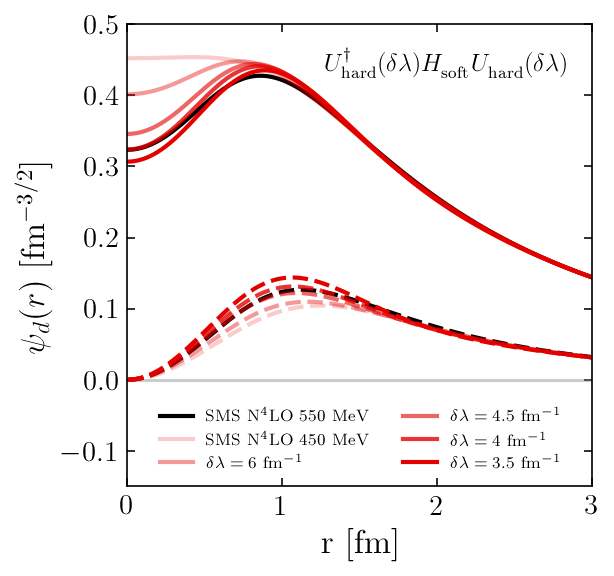

In [39]:
# Compare the SMS N4LO 550 MeV and 450 MeV deuteron wave functions in r-space

kvnn_soft = 111 # 450 MeV
kvnn_hard = 113 # 550 MeV

# \lambda values
# lambda_array = np.array([6.0, 4.5, 4.0, 3.0])
lambda_array = np.array([6.0, 4.5, 4.0, 3.5])
# xlim = (0, 5)
xlim = (0, 3)
ylim = (-0.15, 0.5)

f, ax = deuteron_scale_dependence_inv_r(
    kvnn_soft, kvnn_hard, lambda_array, kmax, kmid, ntot, xlim=xlim,
    ylim=ylim
)

# Add legend
legend_size = 8
legend_location = 'lower center'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add inverse-SRG-evolved Hamiltonian label
label = (r'$U^{\dagger}_{\rm{hard}}(\delta \lambda)$'
         r'$H^{\phantom{\dagger}}_{\rm{soft}}$'
         r'$U^{\phantom{\dagger}}_{\rm{hard}}(\delta \lambda)$')
label_location = 'upper right'
label_size = 12
anchored_text = AnchoredText(label, loc=label_location, frameon=False,
                             prop=dict(size=label_size))
ax.add_artist(anchored_text)

# Set file name
file_name = 'deuteron_scale_dependence_inv_r' \
    + f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

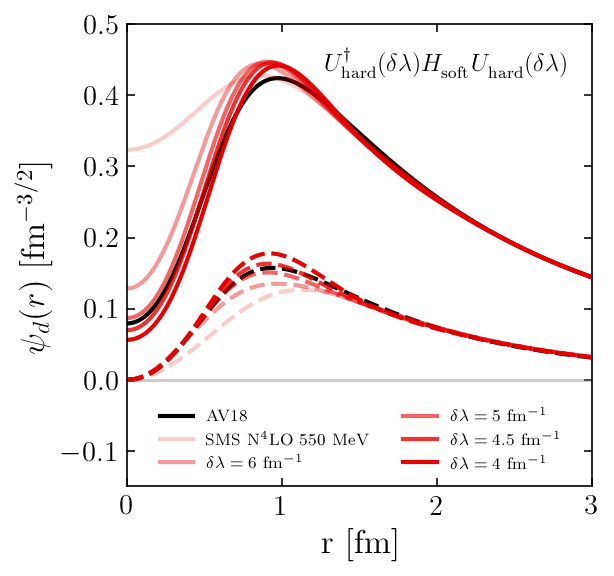

In [40]:
# Compare AV18 and SMS N4LO 550 MeV deuteron wave functions in r-space

kvnn_soft = 113 # 550 MeV
kvnn_hard = 6 # AV18

# \lambda values
# lambda_array = np.array([6.0, 4.5, 4.0, 3.0])
lambda_array = np.array([6.0, 5.0, 4.5, 4.0])
xlim = (0, 3)
ylim = (-0.15, 0.5)

f, ax = deuteron_scale_dependence_inv_r(
    kvnn_soft, kvnn_hard, lambda_array, kmax, kmid, ntot, xlim=xlim,
    ylim=ylim
)

# Add legend
legend_size = 8
legend_location = 'lower center'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add inverse-SRG-evolved Hamiltonian label
label = (r'$U^{\dagger}_{\rm{hard}}(\delta \lambda)$'
         r'$H^{\phantom{\dagger}}_{\rm{soft}}$'
         r'$U^{\phantom{\dagger}}_{\rm{hard}}(\delta \lambda)$')
label_location = 'upper right'
label_size = 12
anchored_text = AnchoredText(label, loc=label_location, frameon=False,
                             prop=dict(size=label_size))
ax.add_artist(anchored_text)

# Set file name
file_name = 'deuteron_scale_dependence_inv_r' \
    + f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [41]:
# Compare AV18 and GT+ N2LO 1 fm deuteron wave functions in r-space

kvnn_soft = 222 # GT+ N2LO 1 fm MeV
kvnn_hard = 6 # AV18

# \lambda values
# lambda_array = np.array([6.0, 4.5, 4.0, 3.0])
lambda_array = np.array([6.0, 5.0, 4.5, 4.0])
xlim = (0, 3)
ylim = (-0.15, 0.5)

f, ax = deuteron_scale_dependence_inv_r(
    kvnn_soft, kvnn_hard, lambda_array, kmax, kmid, ntot, xlim=xlim,
    ylim=ylim
)

# Add legend
legend_size = 8
legend_location = 'lower center'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)\

# Add inverse-SRG-evolved Hamiltonian label
label = (r'$U^{\dagger}_{\rm{hard}}(\delta \lambda)$'
         r'$H^{\phantom{\dagger}}_{\rm{soft}}$'
         r'$U^{\phantom{\dagger}}_{\rm{hard}}(\delta \lambda)$')
label_location = 'upper right'
label_size = 12
anchored_text = AnchoredText(label, loc=label_location, frameon=False,
                             prop=dict(size=label_size))
ax.add_artist(anchored_text)

# Set file name
file_name = 'deuteron_scale_dependence_inv_r' \
    + f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

[[-8.65005736e-02  1.42576226e+01  2.21897614e+00 ... -6.17624748e-09
   2.00310026e-09 -2.69061270e-07]
 [-1.44254421e+01 -8.39118156e-02  2.68490223e+00 ... -6.16969401e-09
   2.01760308e-09 -2.66898849e-07]
 [-2.38674352e+00 -2.85268181e+00 -8.38827024e-02 ... -6.13471080e-09
   2.09176246e-09 -2.55940130e-07]
 ...
 [-6.04957279e-08 -6.04984503e-08 -6.05138363e-08 ... -2.28499997e-06
   5.31611215e-05  6.67406683e-05]
 [-6.46442789e-08 -6.46575236e-08 -6.47265445e-08 ... -5.66994468e-05
  -1.91172094e-06  3.22351452e-05]
 [ 2.09111491e-07  2.06944624e-07  1.95977175e-07 ... -6.95033362e-05
  -3.58439917e-05 -1.86018994e-06]]
[[-9.10745096e-02  1.43485472e+01  2.22932780e+00 ... -5.93711458e-08
  -6.07914960e-08 -3.44566715e-07]
 [-1.45267265e+01 -8.90916480e-02  2.70245646e+00 ... -5.93649323e-08
  -6.07775002e-08 -3.42404814e-07]
 [-2.40745366e+00 -2.88059462e+00 -8.90616990e-02 ... -5.93302381e-08
  -6.07034455e-08 -3.31445088e-07]
 ...
 [-5.30642988e-08 -5.30670230e-08 -5.3082065

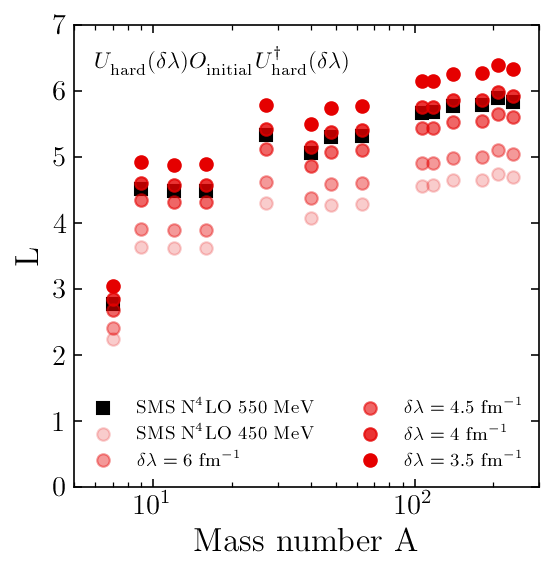

In [42]:
# Connect L values of SMS N4LO 450 MeV to 550 MeV for all experimental points

kvnn_soft = 111
kvnn_hard = 113

# lambda_array = np.array( [6.0, 5.0, 4.0, 3.5] )
lambda_array = np.array( [6.0, 4.5, 4.0, 3.5] )
lambda_final = 1.35

# Set relative momentum values over a lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

ylim = (0, 7)

t0 = time.time()
f, ax = plot_levinger_inverse_srg(
    q_range, nuclei_exp, channels, kvnn_soft, kvnn_hard, lambda_array,
    lambda_final, kmax, kmid, ntot, edf, ylim=ylim
)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Add legend
legend_size = 9
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add inverse-SRG-evolved Hamiltonian label
label = (r'$U^{\phantom{\dagger}}_{\rm{hard}}(\delta \lambda)$'
         r'$O^{\phantom{\dagger}}_{\rm{initial}}$'
         r'$U^{\dagger}_{\rm{hard}}(\delta \lambda)$')
label_location = 'upper left'
label_size = 11
anchored_text = AnchoredText(label, loc=label_location, frameon=False,
                             prop=dict(size=label_size))
ax.add_artist(anchored_text)

# Set file name
file_name = f'levinger_inv_srg_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
# Add channels to file name
for ichannel in channels:
    file_name += f'_{ichannel}'
# Add \lambda_initial values to file name
file_name += '_lambdas'
for lamb in lambda_array:
    file_name += f'_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

[[-9.76086981e-02  2.02930197e+01  3.17857217e+00 ...  1.46532321e-07
   8.94577499e-08  2.83234495e-07]
 [-2.04862913e+01 -9.66408325e-02  3.84299216e+00 ...  1.46443497e-07
   8.93506983e-08  2.81384127e-07]
 [-3.37175722e+00 -4.03620493e+00 -9.66021776e-02 ...  1.46057310e-07
   8.88928926e-08  2.72094288e-07]
 ...
 [ 1.21308968e-05  1.21309358e-05  1.21312457e-05 ... -8.82584321e-05
   1.84823387e-04  2.40967227e-04]
 [ 1.16294656e-05  1.16295285e-05  1.16299473e-05 ... -3.58382193e-04
  -8.69979933e-05  8.37995476e-05]
 [ 1.11739794e-05  1.11757942e-05  1.11850775e-05 ... -4.12216366e-04
  -2.56942913e-04 -8.65684377e-05]]
[[-1.06502120e-01  2.11631355e+01  3.31427829e+00 ... -1.68813177e-06
  -1.69300437e-06 -1.47088153e-06]
 [-2.13678888e+01 -1.02382884e-01  4.00671893e+00 ... -1.68821892e-06
  -1.69310937e-06 -1.47272980e-06]
 [-3.51893975e+00 -4.21141104e+00 -1.02342125e-01 ... -1.68853758e-06
  -1.69349861e-06 -1.48195060e-06]
 ...
 [ 1.35961596e-05  1.35961989e-05  1.3596535

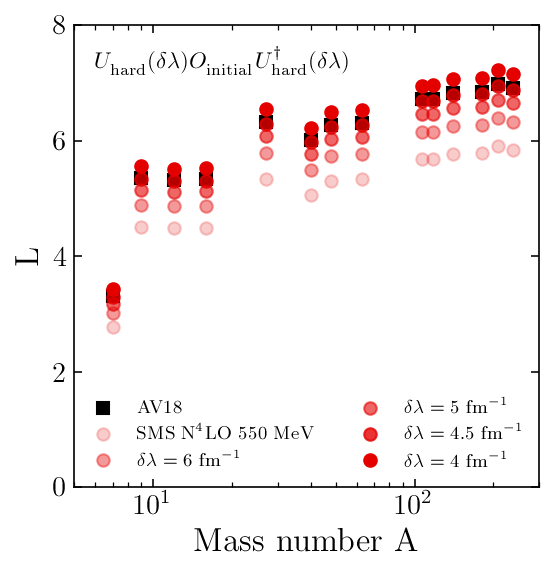

In [65]:
# Connect L values of SMS N4LO 550 MeV to AV18 for all experimental points

kvnn_soft = 113
kvnn_hard = 6

lambda_array = np.array([6.0, 5.0, 4.5, 4.0])
lambda_final = 1.35

# Set relative momentum values over a lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

ylim = (0, 8)

t0 = time.time()
f, ax = plot_levinger_inverse_srg(
    q_range, nuclei_exp, channels, kvnn_soft, kvnn_hard, lambda_array,
    lambda_final, kmax, kmid, ntot, edf, ylim=ylim
)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Add legend
legend_size = 9
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add inverse-SRG-evolved Hamiltonian label
label = (r'$U^{\phantom{\dagger}}_{\rm{hard}}(\delta \lambda)$'
         r'$O^{\phantom{\dagger}}_{\rm{initial}}$'
         r'$U^{\dagger}_{\rm{hard}}(\delta \lambda)$')
label_location = 'upper left'
label_size = 11
anchored_text = AnchoredText(label, loc=label_location, frameon=False,
                             prop=dict(size=label_size))
ax.add_artist(anchored_text)

# Set file name
file_name = f'levinger_inv_srg_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
# Add channels to file name
for ichannel in channels:
    file_name += f'_{ichannel}'
# Add \lambda_initial values to file name
file_name += '_lambdas'
for lamb in lambda_array:
    file_name += f'_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [44]:
# Connect L values of GT+ 1 fm to AV18 for all experimental points

kvnn_soft = 222
kvnn_hard = 6

lambda_array = np.array( [6.0, 4.5, 3.5, 3.0] )
lambda_final = 1.35

# Set relative momentum values over a lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

ylim = (0, 8)

t0 = time.time()
f, ax = plot_levinger_inverse_srg(
    q_range, nuclei_exp, channels, kvnn_soft, kvnn_hard, lambda_array,
    lambda_final, kmax, kmid, ntot, edf, ylim=ylim
)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Add legend
legend_size = 9
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add inverse-SRG-evolved Hamiltonian label
label = (r'$U^{\phantom{\dagger}}_{\rm{hard}}(\delta \lambda)$'
         r'$O^{\phantom{\dagger}}_{\rm{initial}}$'
         r'$U^{\dagger}_{\rm{hard}}(\delta \lambda)$')
label_location = 'upper left'
label_size = 11
anchored_text = AnchoredText(label, loc=label_location, frameon=False,
                             prop=dict(size=label_size))
ax.add_artist(anchored_text)

# Set file name
file_name = f'levinger_inv_srg_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
# Add channels to file name
for ichannel in channels:
    file_name += f'_{ichannel}'
# Add \lambda_initial values to file name
file_name += '_lambdas'
for lamb in lambda_array:
    file_name += f'_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

[[-9.99169554e-02  1.59061012e+01  2.48204920e+00 ...  3.31407071e-06
   3.16484043e-06  2.80497374e-06]
 [-1.60780314e+01 -8.59702285e-02  3.00453872e+00 ...  3.31381286e-06
   3.16458908e-06  2.80686965e-06]
 [-2.65392300e+00 -3.17642924e+00 -8.59389024e-02 ...  3.31346065e-06
   3.16428262e-06  2.81745187e-06]
 ...
 [ 1.27297521e-05  1.27297830e-05  1.27300651e-05 ... -8.89663119e-05
  -7.03203273e-05 -7.45918476e-05]
 [ 1.22664694e-05  1.22664925e-05  1.22667221e-05 ... -1.06238652e-04
  -8.83236130e-05 -7.60575128e-05]
 [ 1.23203932e-05  1.23182592e-05  1.23075912e-05 ... -1.00791904e-04
  -1.00049097e-04 -8.79646969e-05]]
[[-9.52634603e-02  1.69689592e+01  2.64575052e+00 ... -9.65591392e-08
  -1.57817015e-07 -4.68086492e-07]
 [-1.71588538e+01 -9.49502488e-02  3.20273373e+00 ... -9.65925012e-08
  -1.57847267e-07 -4.65971367e-07]
 [-2.83557761e+00 -3.39257919e+00 -9.49163991e-02 ... -9.68196424e-08
  -1.58037036e-07 -4.55277130e-07]
 ...
 [ 1.49697598e-05  1.49697919e-05  1.4970120

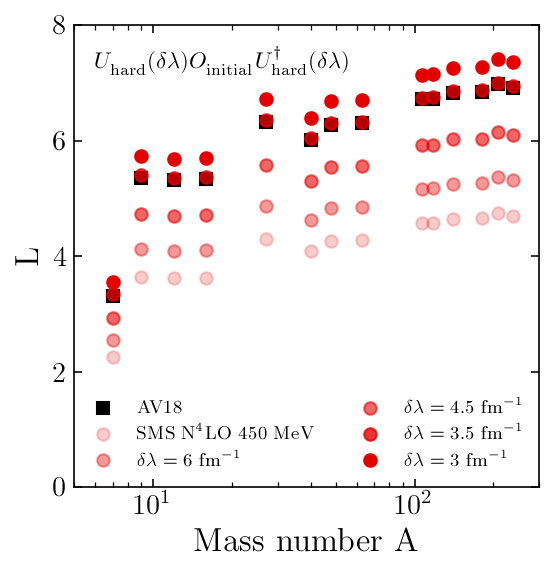

In [45]:
# Connect L values of SMS N4LO 450 MeV to AV18 for all experimental points

kvnn_soft = 111
kvnn_hard = 6

lambda_array = np.array( [6.0, 4.5, 3.5, 3.0] )
lambda_final = 1.35

# Set relative momentum values over a lower momentum range
q_min, q_max, q_step = 2.5, 3.4, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

ylim = (0, 8)

t0 = time.time()
f, ax = plot_levinger_inverse_srg(
    q_range, nuclei_exp, channels, kvnn_soft, kvnn_hard, lambda_array,
    lambda_final, kmax, kmid, ntot, edf, ylim=ylim
)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Add legend
legend_size = 9
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add inverse-SRG-evolved Hamiltonian label
label = (r'$U^{\phantom{\dagger}}_{\rm{hard}}(\delta \lambda)$'
         r'$O^{\phantom{\dagger}}_{\rm{initial}}$'
         r'$U^{\dagger}_{\rm{hard}}(\delta \lambda)$')
label_location = 'upper left'
label_size = 11
anchored_text = AnchoredText(label, loc=label_location, frameon=False,
                             prop=dict(size=label_size))
ax.add_artist(anchored_text)

# Set file name
file_name = f'levinger_inv_srg_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}'
# Add channels to file name
for ichannel in channels:
    file_name += f'_{ichannel}'
# Add \lambda_initial values to file name
file_name += '_lambdas'
for lamb in lambda_array:
    file_name += f'_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

# Asymptotic relation of pair and single-nucleon momentum distributions:
\begin{aligned}
n_p(q) = 2F_{pp}(q)+F_{pn}(k)
\end{aligned}

In [46]:
def verify_asymptotic_relation(
        nucleus, channels, kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
        edf='SLY4', normalizations=False, xlim=(0.0, 5.0), ylim=(1e-3, 5e4)):
    """
    Check the asymptotic relation between the single-nucleon and pair momentum
    distributions. Compare to VMC calculations when possible.
    
    Parameters
    ----------
    nucleus : tuple
        Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g.,
        ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    normalizations : bool, optional
        Option to print out normalizations of momentum distributions.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Low RG resolution calculation --- # 
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    
    # Initialize single momentum distribution class
    snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax,
                                                 kmid, ntot)

    # Try using interpolated versions first
    try:
    
        n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        snmd.write_file(nucleus_name, 'proton', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated versions
        n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)

    # Try using interpolated versions first
    try:
    
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
        n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        pmd.write_file(nucleus_name, 'pn', Z, N, edf)
        pmd.write_file(nucleus_name, 'pp', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated versions
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
        n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)
    
    # Set relative momentum values
    potential = Potential(kvnn, '1S0', kmax, kmid, ntot)
    q_array, q_weights = potential.load_mesh()
    
    # Calculate proton momentum distribution
    n_p_array = n_p_func(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)

    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np
    n_pp_array_2d = n_pp_func.ev(q_mesh, Q_mesh)

    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3

    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    n_pp_array = factor * np.sum(dQ_mesh * n_pp_array_2d, axis=-1)
    
    # Check normalizations?
    if normalizations:
        
        # Proton momentum distribution normalization
        p_norm = factor * np.sum(q_weights * q_array**2 * n_p_array)
        print(f'Proton distribution normalization = {p_norm:.5f}.')
        
        # Proton-neutron pair momentum distribution normalization
        pn_norm = factor * np.sum(q_weights * q_array**2 * n_pn_array)
        print(f'Proton-neutron distribution normalization = {pn_norm:.5f}.')
        
        # Proton-proton pair momentum distribution normalization
        pp_norm = factor * np.sum(q_weights * q_array**2 * n_pp_array)
        print(f'Proton-proton distribution normalization = {pp_norm:.5f}.')
        
        
    # --- Set-up figure --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n_{\lambda}^A(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Add curves to figure
    ax.plot(q_array, n_p_array, color='xkcd:red', label=r'$n_p(q)$',
            linewidth=curve_width)
    ax.plot(q_array, 2*n_pp_array + n_pn_array, color='xkcd:blue',
            label=r'$2n_{pp}(q) + n_{np}(q)$', linewidth=curve_width)
    
    
    # --- Add in VMC data wherever possible --- #
    if nucleus_name in ['He4', 'He8', 'Be9', 'C12']:
        
        # Proton distribution
        vmc_snmd_data = np.loadtxt(
            vmc_data_directory + f'/AV18_{nucleus_name}_snmd.txt'
            )
        if nucleus == 'Be9':
            q_array_p_vmc = vmc_snmd_data[:, 0]
            n_p_array_vmc = vmc_snmd_data[:, 3]
            error_bars_array_vmc = vmc_snmd_data[:, 4]
        else:
            q_array_p_vmc = vmc_snmd_data[:, 0]
            n_p_array_vmc = vmc_snmd_data[:, 1]
            error_bars_array_vmc = vmc_snmd_data[:, 2]
            
        # Pair
        vmc_pmd_data = np.loadtxt(
            vmc_data_directory + f'/AV18_{nucleus_name}_pmd_q.txt'
            )
        q_array_NN_vmc = vmc_pmd_data[:, 0] # fm^-1
        if nucleus == 'He8' or nucleus == 'Be9':
            n_pn_array_vmc = vmc_pmd_data[:, 3]
            pn_error_bars_array_vmc = vmc_pmd_data[:, 4]
            n_pp_array_vmc = vmc_pmd_data[:, 5]
            pp_error_bars_array_vmc = vmc_pmd_data[:, 6]
        else:
            n_pn_array_vmc = vmc_pmd_data[:, 1]
            pn_error_bars_array_vmc = vmc_pmd_data[:, 2]
            n_pp_array_vmc = vmc_pmd_data[:, 3]
            pp_error_bars_array_vmc = vmc_pmd_data[:, 4]
        
        # Plot VMC data with error bars
        ax.plot(q_array_p_vmc, n_p_array_vmc, color='xkcd:red',
                label='VMC proton', linestyle='', marker='.')
        ax.plot(q_array_NN_vmc, 2*n_pp_array_vmc + n_pn_array_vmc,
                color='xkcd:blue', label='VMC pair', linestyle='', marker='.')
        
        # Check VMC normalizations?
        if normalizations:
            
            # Proton momentum distribution normalization
            p_vmc_norm = factor * np.sum(
                0.1 * q_array_p_vmc**2 * n_p_array_vmc
                )
            print(
                f'VMC proton distribution normalization = {p_vmc_norm:.5f}.'
                )
        
            # Proton-neutron pair momentum distribution normalization
            pn_vmc_norm = factor * np.sum(
                0.1 * q_array_NN_vmc**2 * n_pn_array_vmc
                )
            print(
                f'VMC pn distribution normalization = {pn_vmc_norm:.5f}.'
                )
        
            # Proton-proton pair momentum distribution normalization
            pp_vmc_norm = factor * np.sum(
                0.1 * q_array_NN_vmc**2 * n_pp_array_vmc
                )
            print(
                f'VMC pp distribution normalization = {pp_vmc_norm:.5f}.'
                )
        
        
    # --- Finish figure --- #

    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey', alpha=0.3)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [47]:
# C12 (and check normalizations)

nucleus = ('C12', 6, 6)
kvnn = 6

f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb,
                                   normalizations=True)

# Add legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add nucleus label
label = label_nucleus(nucleus[0])
label_location = 'lower left'
label_size = 18
anchored_text = AnchoredText(label, loc=label_location,
                             prop=dict(size=label_size), frameon=False)
ax.add_artist(anchored_text)

# Set file name
file_name = f'asymptotic_relation_{nucleus[0]}'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [48]:
# He4

nucleus = ('He4', 2, 2)
kvnn = 6
ylim = (1e-3, 3e4)

f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb, ylim=ylim)

# Add legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add nucleus label
label = label_nucleus(nucleus[0])
label_location = 'lower left'
label_size = 18
anchored_text = AnchoredText(label, loc=label_location,
                             prop=dict(size=label_size), frameon=False)
ax.add_artist(anchored_text)

# Set file name
file_name = f'asymptotic_relation_{nucleus[0]}'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [49]:
# Ca48

nucleus = ('Ca48', 20, 28)
kvnn = 6
ylim = (1e-2, 1e5)

f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb, ylim=ylim)

# Add legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add nucleus label
label = label_nucleus(nucleus[0])
label_location = 'lower left'
label_size = 18
anchored_text = AnchoredText(label, loc=label_location,
                             prop=dict(size=label_size), frameon=False)
ax.add_artist(anchored_text)

# Set file name
file_name = f'asymptotic_relation_{nucleus[0]}'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

# Extras

### Compare $pn$ and $d$ momentum distributions.

In [50]:
def plot_momentum_dist(
        nucleus, channels, kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
        edf='SLY4', wave_func=False, xlim=(0.0, 5.0), ylim=(1e-3, 1e3)):
    '''Compare deuteron and pn pair momentum distributions given a nucleus.'''
    
    
    # --- Low RG resolution calculation --- #
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    A = N+Z
    
    # Set relative momentum values over [0, 5] fm^-1
    q_min, q_max, q_step = 0.0, xlim[-1], 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    factor = 4*np.pi/(2*np.pi)**3
            
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only ignoring isolated I, \delta U, \delta U^2
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_array)
        
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights,
                                 indexing='ij')
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)

    # Try using interpolated version first
    try:
    
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        pmd.write_file(nucleus_name, 'pn', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated version
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)

    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of two for pn+np

    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
    # Add |\psi_d(q)|^2
    if wave_func:
        
        potential = Potential(kvnn, '3S1', kmax, kmid, ntot)
        
        # Initial Hamiltonian to load deuteron wave function [MeV]
        H_initial = potential.load_hamiltonian()
        
        psi_unitless = wave_function(H_initial)
        
        # Momenta and weights of Hamiltonian
        k_array, k_weights = potential.load_mesh()
        ntot_k = ntot
        factor_array = 2/np.pi * k_weights * k_array**2
        
        # Deuteron momentum distribution
        psi2_array = ((psi_unitless[:ntot]**2 + psi_unitless[ntot:]**2)
                     / factor_array * (2*np.pi)**3 / (4*np.pi) * (2/np.pi))
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'n(q) [fm' + r'$^3$' + ']'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set y-axis to log scale
    ax.set_yscale('log')

    # Plot ratio with respect to momentum
    if wave_func:
        ax.plot(k_array, psi2_array, label=r'$|\psi_d(q)|^2$',
                linewidth=curve_width, color='xkcd:red')
    ax.plot(q_array, n_d_array, label='d', linewidth=curve_width,
            color='xkcd:black')
    ax.plot(q_array, n_pn_array, label='pn', linewidth=curve_width,
            color='xkcd:blue')
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    # Set legend
    legend_size = 14
    legend_location = 'upper right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

    # Add kvnn and nucleus label
    label = (f'{label_nucleus(nucleus_name)}\n'
             f'{label_kvnn(kvnn)}')
    label_location = 'lower left'
    label_size = 15
    anchored_text = AnchoredText(label, loc=label_location,
                                 prop=dict(size=label_size), frameon=False)
    ax.add_artist(anchored_text);

In [51]:
# AV18 C12
kvnn = 6
plot_momentum_dist(('C12', 6, 6), channels, kvnn, lamb, wave_func=True,
                   xlim=(0, 6), ylim=(1e-5, 1e3))

In [52]:
# GT+ N2LO 1 fm, C12
kvnn = 222
plot_momentum_dist(('C12', 6, 6), channels, 222, lamb, kmax, kmid, ntot,
                   wave_func=True, xlim=(0.0, 6.0), ylim=(1e-5, 1e3))

In [53]:
# SMS N4LO 450 MeV C12
kvnn = 111
plot_momentum_dist(
    ('C12', 6, 6), channels, 111, lamb, kmax, kmid, ntot, xlim=(0, 6),
    ylim=(1e-5, 1e3)
)

In [54]:
# SMS N4LO 550 MeV C12
kvnn = 113
plot_momentum_dist(('C12', 6, 6), channels, 113, lamb, kmax, kmid, ntot,
                   wave_func=True, xlim=(0, 6), ylim=(1e-5, 1e3))

In [55]:
def plot_d_momentum_dist(
        channels, kvnns, lamb, kmax=15.0, kmid=3.0, ntot=120, xlim=(0.0, 8.0),
        ylim=(1e-3, 1e3)):
    '''Compare deuteron momentum distributions for multiple potentials.'''
    
    
    # --- Low RG resolution calculation --- #

    # Set relative momentum values
    q_min, q_max, q_step = xlim[0], xlim[1], 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Loop over kvnns and store deuteron distributions in dictionary
    d = {}
    
    for kvnn in kvnns:
    
        # Initialize deuteron momentum distribution class
        dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                              interp=True)
    
        # Get interpolated functions of deuteron momentum distribution
        # Ignore the 1, \delta U, and \delta U^2 isolated contributions
        n_d_func, _, _, _ = dmd.n_lambda_interp()
    
        # Calculate deuteron momentum distribution
        d[kvnn] = n_d_func(q_array)
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n_d(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Loop over kvnns and add each curve to plot
    for i, kvnn in enumerate(kvnns):
        
        # Label and color
        curve_color = ff.xkcd_colors(i)
        curve_label = label_kvnn(kvnn)

        # Plot momentum distribution
        ax.plot(q_array, d[kvnn], label=curve_label, linewidth=curve_width,
                color=curve_color)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    # Set legend
    legend_size = 9
    legend_location = 'lower left'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

    # Add nucleus label
    label = 'deuteron'
    label_location = 'upper right'
    label_size = 16
    anchored_text = AnchoredText(label, loc=label_location,
                                 prop=dict(size=label_size), frameon=False)
    ax.add_artist(anchored_text);

In [56]:
def plot_pn_momentum_dist(
        nucleus, channels, kvnns, lamb, kmax=15.0, kmid=3.0, ntot=120, 
        edf='SLY4', xlim=(0.0, 8.0), ylim=(1e-3, 1e3)):
    '''
    Compare pn relative momentum distributions for multiple potentials
    given a nucleus.
    '''
    
    # --- Low RG resolution calculation --- #
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    A = N+Z

    # Set relative momentum values
    q_min, q_max, q_step = xlim[0], xlim[1], 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Loop over kvnns and store deuteron distributions in dictionary
    d = {}
    
    for kvnn in kvnns:
    
        # Initialize pair momentum distribution class
        pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid,
                                          ntot)

        # Use interpolated version
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                 edf)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        d[kvnn] = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n_{pn}(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Loop over kvnns and add each curve to plot
    for i, kvnn in enumerate(kvnns):
        
        # Label and color
        curve_color = ff.xkcd_colors(i)
        curve_label = label_kvnn(kvnn)

        # Plot momentum distribution
        ax.plot(q_array, d[kvnn], label=curve_label, linewidth=curve_width,
                color=curve_color)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    # Set legend
    legend_size = 9
    legend_location = 'lower left'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

    # Add nucleus label
    label = label_nucleus(nucleus_name)
    label_location = 'upper right'
    label_size = 18
    anchored_text = AnchoredText(label, loc=label_location,
                                 prop=dict(size=label_size), frameon=False)
    ax.add_artist(anchored_text);

In [57]:
# Compare momentum distributions for the following potentials

kvnns = [6, 111, 113, 222, 224]

In [58]:
# Deuteron momentum distributions

ylim = (1e-6, 1e1)
plot_d_momentum_dist(channels, kvnns, lamb, kmax, kmid, ntot, ylim=ylim)

In [59]:
# pn relative momentum distributions in Ca48

nucleus_test = ('Ca40', 20, 20)
ylim = (1e-5, 1e2)

plot_pn_momentum_dist(nucleus_test, channels, kvnns, lamb, kmax, kmid, ntot,
                      edf, ylim=ylim)

### Testing out different $pn/d$ ratios

In [60]:
# AV18 with SLy4

kvnn = 6

f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
                            ntot, 'SLY4')

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_SLY4'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [61]:
# AV18 with Gogny and only 3S1-3D1 channel

kvnn = 6

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = label_kvnn(kvnn)
edf_label = 'Gogny'
lambda_label = label_lambda(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [62]:
# GT+ 1 fm with Gogny and only 3S1-3D1 channel

kvnn = 222

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = label_kvnn(kvnn)
edf_label = 'Gogny'
lambda_label = label_lambda(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [63]:
# GT+ 1.2 fm with Gogny and only 3S1-3D1 channel

kvnn = 224

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = label_kvnn(kvnn)
edf_label = 'Gogny'
lambda_label = label_lambda(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [64]:
# SMS N4LO 450 MeV with Gogny and only 3S1-3D1 channel

kvnn = 111

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = label_kvnn(kvnn)
edf_label = 'Gogny'
lambda_label = label_lambda(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

OSError: data/dmd/kvnn_111/deuteron_lamb_3p00_kmax_15p0.dat not found.

In [ ]:
# SMS N4LO 550 MeV with Gogny and only 3S1-3D1 channel

kvnn = 113

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = label_kvnn(kvnn)
edf_label = 'Gogny'
lambda_label = label_lambda(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# AV18 with Gogny and some P-waves

kvnn = 6

f, ax = plot_levinger_ratio(example_nuclei, channels_pwaves, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = label_kvnn(kvnn)
edf_label = 'Gogny'
lambda_label = label_lambda(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_pwaves:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# AV18 with Gogny but \lambda = 2, 3, and 6 fm^-1

kvnn = 6

# Loop over higher \lambda values
for i, ilamb in enumerate(lambdas):
    
    f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, ilamb, kmax,
                                kmid, ntot, edf)

    # Set legend
    legend_size = 12
    legend_location = 'upper right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size,
              ncol=2)
    
    # Set title
    kvnn_label = label_kvnn(kvnn)
    edf_label = 'Gogny'
    lambda_label = label_lambda(ilamb)
    title = f'{kvnn_label}, {edf_label}, {lambda_label}'
    title_size = 12
    ax.set_title(title, fontsize=title_size)

    # Set file name
    file_name = 'levinger_ratio'
    for inucleus in example_nuclei:
        file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
    for ichannel in channels:
        file_name += '_%s' % ichannel # (e.g., '1S0')
    file_name += f'_kvnn_{kvnn}_lamb_{ilamb:.2f}_{edf}'
    file_name = ff.replace_periods(file_name) + '.png'

    # Save figure
    f.savefig(figure_directory + '/' + file_name)

In [ ]:
# AV18 with Gogny and |\psi_d(q)|^2 instead of HF+LDA deuteron momentum
# distribution

kvnn = 6

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf, wave_func=True)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text);

In [ ]:
# GT+ N2LO 1 fm with |\psi_d(q)|^2 instead of HF+LDA deuteron momentum
# distribution

kvnn = 222

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf, wave_func=True)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text);

In [ ]:
# SMS N4LO 550 MeV with |\psi_d(q)|^2 instead of HF+LDA deuteron momentum
# distribution

kvnn = 113

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf, wave_func=True)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add potential label
kvnn_label = label_kvnn(kvnn)
kvnn_label_location = 'lower right'
kvnn_label_size = 15
anchored_text = AnchoredText(
    kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size)
)
ax.add_artist(anchored_text);

### Testing other $L$ tables

In [ ]:
# GT+ N2LO 1.2 fm
# This potential never has a flat pn/d ratio!

kvnn = 224

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

### Look at scale dependence of $pn/d$ ratio

In [ ]:
# Takes about ~3 minutes to run for each \lambda value
def levinger_ratio_scale_dependence(
        nucleus, kvnn_soft, kvnn_hard, lambda_array, lambda_final, kmax=15.0,
        kmid=3.0, ntot=120, edf='Gogny', xlim=(0, 5), ylim=(0.0, 15.0)):
    """
    Compare the pn/d momentum distributions ratio between soft and hard
    potentials where we evolve the harder of the two to match the softer one
    using SRG transformations. Here we treat the Hamiltonian evolved to a
    matching \lambda (from lambda_array) as the initial Hamiltonian. Then we
    compute the momentum distributions taking the Hamiltonian evolved to a 
    low RG resolution scale (lambda_final) as the evolved Hamiltonian.

    Parameters
    ----------
    nucleus : tuple
        Details for some nucleus formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
    kvnn_soft : int
        This number specifies the softer potential.
    kvnn_hard : int
        This number specifies the harder potential.
    lambda_array : 1-D ndarray
        \lambda evolution values [fm^-1].
    lambda_final : float
        SRG \lambda parameter for low RG resolution scale [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    A = N+Z
    
    # Get nucleonic densities
    R_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N, edf)
    R_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N, edf)
    dR = R_array[2] - R_array[1] # Assuming linear spacing
    
    # Set relative momentum values over [0, 5] fm^-1
    q_min, q_max, q_step = 0.0, xlim[-1], 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    
    # --- Calculate for soft potential first --- #
    
    # Initialize deuteron momentum distribution class
    dmd_soft_init = deuteron_momentum_distributions(
        kvnn_soft, lambda_final, kmax, kmid, ntot, interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only ignoring isolated I, \delta U, \delta U^2
    n_d_soft_init_func, _, _, _ = dmd_soft_init.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_soft_init_array = n_d_soft_init_func(q_array)
    
    # Initialize pair momentum distribution class
    pmd_soft_init = pair_momentum_distributions(
        kvnn_soft, channels, lambda_final, kmax, kmid, ntot, interp=True)
    
    # Get interpolated function of pair momentum distribution
    n_pn_soft_init_func, _, _, _ = pmd_soft_init.n_lambda_interp(
        nucleus_name, 'pn', Z, N, edf)

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_soft_init_array_2d = 2*n_pn_soft_init_func.ev(q_mesh, Q_mesh)
    
    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_soft_init_array = factor * np.sum(dQ_mesh * n_pn_soft_init_array_2d,
                                           axis=-1)
    
    # Calculate ratio
    ratio_soft_init_array = A/(N*Z) \
                            * n_pn_soft_init_array / n_d_soft_init_array
    
    
    # --- Calculate for hard potential next --- #
    
    # Initialize deuteron momentum distribution class
    dmd_hard_init = deuteron_momentum_distributions(
        kvnn_hard, lambda_final, kmax, kmid, ntot, interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only ignoring isolated I, \delta U, \delta U^2
    n_d_hard_init_func, _, _, _ = dmd_hard_init.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_hard_init_array = n_d_hard_init_func(q_array)
    
    # Initialize pair momentum distribution class
    pmd_hard_init = pair_momentum_distributions(
        kvnn_hard, channels, lambda_final, kmax, kmid, ntot, interp=True)
    
    # Get interpolated function of pair momentum distribution
    n_pn_hard_init_func, _, _, _ = pmd_hard_init.n_lambda_interp(
        nucleus_name, 'pn', Z, N, edf)

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_hard_init_array_2d = 2*n_pn_hard_init_func.ev(q_mesh, Q_mesh)
    
    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_hard_init_array = factor * np.sum(dQ_mesh * n_pn_hard_init_array_2d,
                                           axis=-1)
    
    # Calculate ratio
    ratio_hard_init_array = A/(N*Z) \
                            * n_pn_hard_init_array / n_d_hard_init_array
    
    
    # --- Calculate with hard potential evolved as the starting point --- #
    
    # Loop over \lambda values and store pn/d ratios in dictionary
    d = {}
    for lamb in lambda_array:
        
        # Get SRG-evolved Hamiltonian to \lambda and use that as H_initial
        # ....
    
        # Initialize deuteron momentum distribution class
        dmd_hard_srg = deuteron_momentum_distributions(
            kvnn_hard, lambda_final, kmax, kmid, ntot, interp=False,
            lambda_init=lamb)
    
        # Calculate deuteron momentum distribution
        n_d_hard_srg_array = dmd_hard_srg.n_total(q_array, R_array, dR)
    
        # Initialize pair momentum distribution class
        pmd_hard_srg = pair_momentum_distributions(
            kvnn_hard, channels, lambda_final, kmax, kmid, ntot, interp=False,
            lambda_init=lamb)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_hard_srg_array_2d = 2*pmd_hard_srg.n_total(
            q_array, Q_array, R_array, dR, rho_p_array, rho_n_array)
    
        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_hard_srg_array = factor * np.sum(
            dQ_mesh * n_pn_hard_srg_array_2d, axis=-1)
    
        # Calculate ratio and store in dictionary with \lambda_match as key
        d[lamb] = A/(N*Z) * n_pn_hard_srg_array / n_d_hard_srg_array

    
    # --- Plot --- #
    
    # Set-up average value of L
    L_mean = 5.5
    L_sig = 0.21
    
    # Convert L +/- L_sigma to arrays for errorbands
    L_upper_array = np.ones(ntot_q) * (L_mean + L_sig)
    L_lower_array = np.ones(ntot_q) * (L_mean - L_sig)
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$\frac{A}{NZ} \frac{ n_{pn}^A(q) }{ n_{p}^d(q) }$'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Add Levinger constant to figure (L = 5.5 +/- 0.21)
    ax.fill_between(q_array, y1=L_lower_array, y2=L_upper_array,
                    color='gray', alpha=0.5)
    
    # Hard potential first
    ax.plot(
        q_array, ratio_hard_init_array, color='xkcd:black',
        linestyle='solid', linewidth=curve_width, 
        label=label_kvnn(kvnn_hard))
    
    # Soft potential second
    ax.plot(
        q_array, ratio_soft_init_array, color='xkcd:red',
        linewidth=curve_width, linestyle='solid',
        label=label_kvnn(kvnn_soft))
    
    # Loop over \lambda values and add to plot
    for i, lamb in enumerate(lambda_array):
        
        curve_color = ff.xkcd_colors(i+2)
        ax.plot(
            q_array, d[lamb], linewidth=1.5, color=curve_color,
            linestyle='dashed', label=label_lambda(lamb))

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [ ]:
# Test C12 with SMS N4LO potentials at 550 MeV and 450 MeV

nucleus_test = ('C12', 6, 6)
kvnn_soft = 111
kvnn_hard = 113
lambda_array = np.array([4.5]) # Just do one \lambda value for now
lambda_final = 1.35

t0 = time.time()
f, ax = levinger_ratio_scale_dependence(
    nucleus_test, kvnn_soft, kvnn_hard, lambda_array, lambda_final, kmax,
    kmid, ntot, edf)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Set legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'levinger_ratio_scale_dependence' + \
    f'{nucleus_test[0]}_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}' + \
    f'_lambda_final_{lambda_final:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Test C12 with AV18 and SMS N4LO 550 MeV

nucleus_test = ('C12', 6, 6)
kvnn_soft = 113
kvnn_hard = 6
lambda_array = np.array([6.0, 4.5, 4.0])
lambda_final = 1.35

t0 = time.time()
f, ax = levinger_ratio_scale_dependence(
    nucleus_test, kvnn_soft, kvnn_hard, lambda_array, lambda_final, kmax,
    kmid, ntot, edf)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Set legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'levinger_ratio_scale_dependence' + \
    f'{nucleus_test[0]}_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}' + \
    f'_lambda_final_{lambda_final:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Test C12 with AV18 and SMS N4LO 450 MeV

nucleus_test = ('C12', 6, 6)
kvnn_soft = 111
kvnn_hard = 6
lambda_array = np.array([6.0, 4.5, 4.0])
lambda_final = 1.35

t0 = time.time()
f, ax = levinger_ratio_scale_dependence(
    nucleus_test, kvnn_soft, kvnn_hard, lambda_array, lambda_final, kmax,
    kmid, ntot, edf)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Set legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'levinger_ratio_scale_dependence' + \
    f'{nucleus_test[0]}_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}' + \
    f'_lambda_final_{lambda_final:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Test C12 with AV18 and GT+ 1 fm

nucleus_test = ('C12', 6, 6)
kvnn_soft = 222
kvnn_hard = 6
lambda_array = np.array([6.0, 4.5, 4.0])
lambda_final = 1.35

t0 = time.time()
f, ax = levinger_ratio_scale_dependence(
    nucleus_test, kvnn_soft, kvnn_hard, lambda_array, lambda_final, kmax,
    kmid, ntot, edf)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Set legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'levinger_ratio_scale_dependence' + \
    f'{nucleus_test[0]}_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}' + \
    f'_lambda_final_{lambda_final:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

### Inverse-SRG-evolution

_Notes_:<br/>

In order to have the correct initial operator associated with a soft chiral potential, there must be an initial two-body piece. Could we use the SRG transformation from connecting AV18 to a soft potential (i.e., $U_{\lambda}$ for $\lambda \sim 4$ fm$^{-1}$) and take the initial operator as $U_{\lambda}(4) a^{\dagger}_{q} a_q U^{\dagger}_{\lambda}(4)$ (which is 2-body)?<br/>

If I think about applying the inverse transformation to the soft potential to make it hard, then I'm doing $H_{\rm{initial}} = U^{\dagger}_{\lambda} H_{\rm{soft}} U_{\lambda}$. Then evolving this Hamiltonian to the low scale of $\lambda=1.35$ fm$^{-1}$ means when we build `U_matrix` in the code, it's really $U_{\lambda}(1.35) U_{\lambda}(4) = \sum_{\alpha} \lvert{\psi(1.35)\rangle} \langle{\psi(4)\rvert}$ since $\lvert{\psi(4)\rangle}=U^{\dagger}_{\lambda}(4) \lvert{\psi(\infty)\rangle}$ are the eigenstates of the "initial" Hamiltonian (note, it's $U^{\dagger}_{\lambda}$ here not $U_{\lambda}$). Then in evolving the initial operator $a^{\dagger}_{q} a_q$, we arrive at $U_{\lambda}(1.35) U_{\lambda}(4) a^{\dagger}_{q} a_q U^{\dagger}_{\lambda}(4) U^{\dagger}_{\lambda}(1.35)$ implying the initial operator is given by $U_{\lambda}(4) a^{\dagger}_{q} a_q U^{\dagger}_{\lambda}(4)$ as above.<br/>

In [ ]:
def plot_potentials(
        k_array, V_list, axes_max=4.0, colorbar_limits=(-1.0, 1.0)):
    """
    Plots a row of NN potentials [fm] with respect to momentum [fm^-1]. This 
    is a 1 x n contour plot where n is the size of V_list.
    
    Parameters
    ----------
    k_array : 1-D ndarray
        Momentum values of the potentials [fm^-1].
    V_list : list
        List of potentials [fm] which are 2-D ndarrays.
    axes_max : float, optional
        Maximum value of momenta for xi and y-axis [fm^-1].
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm] of the colorbar.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Size of figure
    row_number = 1
    col_number = len(V_list)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_lim = (0.0, axes_max)
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    # Step-size in labeling tick marks
    if axes_max <= 5.0:
        axes_stepsize = 1.0
    elif 5.0 < axes_max <= 10.0:
        axes_stepsize = 2.0
    else:
        axes_stepsize = 3.0
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = label_ticks(axes_ticks)
    axes_tick_size = 16
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = label_ticks(levels_ticks)
    colorbar_label = '[fm]'
    colorbar_label_size = 18
    colorbar_tick_size = 18
    
    # Color scheme for contour plots
    color_style = 'turbo'
    

    # --- Loop over potentials and store in dictionary --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over potentials
    for i, V_matrix in enumerate(V_list):
                
        # Interpolate the potential through 0 to axes_max for smoother
        # looking figure (the extension _int means interpolated)
        k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, 
                                                          axes_max + 0.2)
            
        # Store in dictionary with index i as key
        d[i] = V_matrix_int
            
            
    # --- Plot potentials --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=figure_size)
    
    # Loop over potentials keeping track of index and interpolated potential
    for i, V_int in d.items():
            
        c = axs[i].contourf(k_array_int, k_array_int, V_int, levels,
                            cmap=color_style, extend='both')

        # Specify axes limits
        axs[i].set_xlim(axes_lim)
        axs[i].set_ylim(axes_lim)
                                         
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks_strings)
        # Switch from bottom to top
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)

        # Set x-axis label
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
                                         
        # On the left column, set and label y-axis
        if i == 0:
                                         
            # Specify axes tick marks
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks_strings)
            axs[i].tick_params(labelsize=axes_tick_size)
                                         
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size, pad=15)

    return f, axs

In [ ]:
# Compare SMS N4LO 550 MeV and SMS N4LO 450 MeV evolving the softer of the
# two back to the harder potential in 3S1-3S1 channel

kvnn_soft = 111
kvnn_hard = 113
channel_compare = '3S1'
lambda_match = 4.5 # Matching \lambda value

# Get list of potentials ordered as follows:
#   1. Initial hard potential
#   2. Initial soft potential
#   3. Inverse-SRG-evolved soft potential
k_array, V_list = inverse_srg(kvnn_soft, kvnn_hard, channel_compare, 
                              np.array([lambda_match]), kmax, kmid, ntot)

# Plot contours in that order
f, axs = plot_potentials(k_array, V_list, axes_max=5.0)

# Add potential label to each plot
label_size = 14
label_location = 'lower right'
for i, ax in enumerate(axs):
    
    # Create label for each case
    if i == 0: # Initial hard potential
        label = f'{label_kvnn(kvnn_hard)}\n' \
              + f'{label_lambda(np.inf)}'
    elif i == 1: # Initial soft potential
        label = f'{label_kvnn(kvnn_soft)}\n' \
              + f'{label_lambda(np.inf)}'
    else:
        lamb_str = ff.convert_number_to_string(lambda_match)
        label = f'{label_kvnn(kvnn_soft)}\n' \
              + fr'$\delta \lambda={lamb_str}$' + ' fm' + r'$^{-1}$'
        
    anchored_text = AnchoredText( label, loc=label_location,
                                  prop=dict(size=label_size) )
    ax.add_artist(anchored_text)

# Add channel label to first sub-plot
channel_label_size = 20
channel_label_location = 'upper right'
channel_label = label_channel(channel_compare, False)
anchored_text = AnchoredText( channel_label, loc=channel_label_location,
                              prop=dict(size=channel_label_size) )
axs[0].add_artist(anchored_text)

# Set file name
file_name = 'inverse_srg' \
          + f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}' \
          + f'_{channel_compare}_lamb_{lambda_match:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Compare AV18 and GT+ 1 fm

kvnn_soft = 222
kvnn_hard = 6
channel_compare = '3S1'
lambda_match = 5 # Matching \lambda value

# Get list of potentials ordered as follows:
#   1. Initial hard potential
#   2. Initial soft potential
#   3. Inverse-SRG-evolved soft potential
k_array, V_list = inverse_srg(kvnn_soft, kvnn_hard, channel_compare, 
                              np.array([lambda_match]), kmax, kmid, ntot)

# Plot contours in that order
f, axs = plot_potentials(k_array, V_list, axes_max=5.0)

# Add potential label to each plot
label_size = 14
label_location = 'lower right'
for i, ax in enumerate(axs):
    
    # Create label for each case
    if i == 0: # Initial hard potential
        label = f'{label_kvnn(kvnn_hard)}\n' \
              + f'{label_lambda(np.inf)}'
    elif i == 1: # Initial soft potential
        label = f'{label_kvnn(kvnn_soft)}\n' \
              + f'{label_lambda(np.inf)}'
    else:
        lamb_str = ff.convert_number_to_string(lambda_match)
        label = f'{label_kvnn(kvnn_soft)}\n' \
              + fr'$\delta \lambda={lamb_str}$' + ' fm' + r'$^{-1}$'
        
    anchored_text = AnchoredText( label, loc=label_location,
                                  prop=dict(size=label_size) )
    ax.add_artist(anchored_text)

# Add channel label to first sub-plot
channel_label_size = 20
channel_label_location = 'upper right'
channel_label = label_channel(channel_compare, False)
anchored_text = AnchoredText( channel_label, loc=channel_label_location,
                              prop=dict(size=channel_label_size) )
axs[0].add_artist(anchored_text)

# Set file name
file_name = 'inverse_srg' \
          + f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}' \
          + f'{channel_compare}_lamb_{lambda_match:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Compare AV18 and SMS N4LO 450 MeV

kvnn_soft = 111
kvnn_hard = 6
channel_compare = '3S1'
lambda_match = 4.5

# Get list of potentials ordered as follows:
#   1. Initial hard potential
#   2. Initial soft potential
#   3. Inverse-SRG-evolved soft potential
k_array, V_list = inverse_srg(kvnn_soft, kvnn_hard, channel_compare, 
                              np.array([lambda_match]), kmax, kmid, ntot)

# Plot contours in that order
f, axs = plot_potentials(k_array, V_list, axes_max=5.0)

# Add potential label to each plot
label_size = 14
label_location = 'lower right'
for i, ax in enumerate(axs):
    
    # Create label for each case
    if i == 0: # Initial hard potential
        label = f'{label_kvnn(kvnn_hard)}\n' \
              + f'{label_lambda(np.inf)}'
    elif i == 1: # Initial soft potential
        label = f'{label_kvnn(kvnn_soft)}\n' \
              + f'{label_lambda(np.inf)}'
    else:
        lamb_str = ff.convert_number_to_string(lambda_match)
        label = f'{label_kvnn(kvnn_soft)}\n' \
              + fr'$\delta \lambda={lamb_str}$' + ' fm' + r'$^{-1}$'
        
    anchored_text = AnchoredText( label, loc=label_location,
                                  prop=dict(size=label_size) )
    ax.add_artist(anchored_text)

# Add channel label to first sub-plot
channel_label_size = 20
channel_label_location = 'upper right'
channel_label = label_channel(channel_compare, False)
anchored_text = AnchoredText( channel_label, loc=channel_label_location,
                              prop=dict(size=channel_label_size) )
axs[0].add_artist(anchored_text)

# Set file name
file_name = 'inverse_srg' \
          + f'_kvnn_soft_{kvnn_soft}_kvnn_hard_{kvnn_hard}' \
          + f'_{channel_compare}_lamb_{lambda_match:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Takes about ~1/2 a minute for one nucleus
def levinger_constant_inverse_srg(
        q_range, nucleus, channels, kvnn_soft, kvnn_hard, lambda_init,
        lambda_final, kmax=15.0, kmid=3.0, ntot=120, edf='Gogny'):
    
    # --- Set-up --- #
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    A = N+Z
    
    # Get nucleonic densities
    R_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N, edf)
    R_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N, edf)
    dR = R_array[2] - R_array[1] # Assuming linear spacing
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(
        kvnn_soft, lambda_final, kmax, kmid, ntot, interp=False,
        lambda_init=lambda_init, kvnn_hard=kvnn_hard)
    
    # Calculate deuteron momentum distribution
    n_d_array = dmd.n_total(q_range, R_array, dR)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(
        kvnn_soft, channels, lambda_final, kmax, kmid, ntot, interp=False,
        lambda_init=lambda_init, kvnn_hard=kvnn_hard)
    
    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_array_2d = 2*pmd.n_total(q_range, Q_array, R_array, dR, rho_p_array,
                                  rho_n_array)
    
    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)

    # Get mean value of ratio over momentum range and print results
    ratio_array = A/(N*Z) * n_pn_array / n_d_array
    L_avg = np.mean(ratio_array)
    
    print(f'Nucleus = {nucleus_name}, L = {L_avg:.2f}')

### Check how the phenomenological potentials look in momentum space.

In [ ]:
def potential_contours(kvnn, channel, lambda_array, kmax=15.0, kmid=3.0,
                       ntot=120, axes_max=4.0, colorbar_limits=(-1.0, 1.0)):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1].
    This is an 1 x n contour plot where n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    lambda_array : 1-D ndarray
        \lambda evolution values [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    axes_max : float, optional
        Maximum value of momenta for xi and y-axis [fm^-1].
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm] of the colorbar.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    
    # Load momentum
    k_array, _ = potential.load_mesh()
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_lim = (0.0, axes_max)
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    # Step-size in labeling tick marks
    if axes_max <= 5.0:
        axes_stepsize = 1.0
    elif 5.0 < axes_max <= 10.0:
        axes_stepsize = 2.0
    else:
        axes_stepsize = 3.0
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = label_ticks(axes_ticks)
    axes_tick_size = 16
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = label_ticks(levels_ticks)
    colorbar_label = '[fm]'
    colorbar_label_size = 18
    colorbar_tick_size = 18
    
    # Color scheme for contour plots
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over lambda values
    for lamb in lambda_array:
            
        # Load initial potential 
        V_matrix = potential.load_potential('srg', 'Wegner', lamb)
                
        # Interpolate the potential through 0 to axes_max for smoother
        # looking figure (the extension _int means interpolated)
        k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix,
                                                          axes_max + 0.2)
            
        # Store in dictionary with generator and lamb as keys
        d[lamb] = V_matrix_int
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=figure_size)
    
    # Loop over \lambda's keeping track of indices
    for i, lamb in enumerate(lambda_array):
            
        c = axs[i].contourf(k_array_int, k_array_int, d[lamb], levels,
                            cmap=color_style, extend='both')

        # Specify axes limits
        axs[i].set_xlim( axes_lim )
        axs[i].set_ylim( axes_lim )
                                         
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks_strings)
        # Switch from bottom to top
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)

        # Set x-axis label
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
                                         
        # On the left column, set and label y-axis
        if i == 0:
                                         
            # Specify axes tick marks
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks_strings)
            axs[i].tick_params(labelsize=axes_tick_size)
                                         
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [ ]:
# Check for the following \lambda values
lambda_array = np.array( [6, 3, 2, 1.35] )

# kvnn = 1 # Paris
# kvnn = 2 # Bonn
# kvnn = 3 # Reid93
# kvnn = 4 # Nijmegen I
# kvnn = 5 # Nijmegen II
# kvnn = 6 # AV18
# kvnn = 7 # CD-Bonn
# kvnn = 111 # RKE N4LO 450 MeV
kvnn = 113 # RKE N4LO 550 MeV

In [ ]:
# Check all of the new potentials in this cell

# 1S0 channel
channel = '1S0'

axes_max = 5.0
colorbar_lim = (-1, 1)

f, axs = potential_contours(kvnn, channel, lambda_array, kmax, kmid, ntot,
                            axes_max, colorbar_lim)

# Add potential label to third sub-plot
kvnn_label_size = 16
kvnn_label_location = 'upper right'
kvnn_label = label_kvnn(kvnn)
anchored_text = AnchoredText( kvnn_label, loc=kvnn_label_location,
                              prop=dict(size=kvnn_label_size) )
axs[-2].add_artist(anchored_text)

# Add channel label to last sub-plot
channel_label_size = 20
channel_label_location = 'upper right'
if channel == '1S0':
    channel_label = label_channel(channel)
elif channel == '3S1':
    channel_label = r'$^{3}{\rm S}_{1}-^{3}{\rm S}_{1}$'
anchored_text = AnchoredText( channel_label, loc=channel_label_location,
                              prop=dict(size=channel_label_size) )
axs[-1].add_artist(anchored_text)

# Add \lambda label to each sub-plot
lambda_label_size = 17
lambda_label_location = 'lower left'
for i, lamb in enumerate(lambda_array):
    lambda_label = label_lambda(lamb)
    anchored_text = AnchoredText( lambda_label, loc=lambda_label_location,
                                  prop=dict(size=lambda_label_size) )
    axs[i].add_artist(anchored_text)

In [ ]:
# Check all of the new potentials in this cell

# 3S1 channel
channel = '3S1'

axes_max = 5.0
colorbar_lim = (-1, 1)

f, axs = potential_contours(kvnn, channel, lambda_array, kmax, kmid, ntot,
                            axes_max, colorbar_lim)

# Add potential label to third sub-plot
kvnn_label_size = 16
kvnn_label_location = 'upper right'
kvnn_label = label_kvnn(kvnn)
anchored_text = AnchoredText( kvnn_label, loc=kvnn_label_location,
                              prop=dict(size=kvnn_label_size) )
axs[-2].add_artist(anchored_text)

# Add channel label to last sub-plot
channel_label_size = 20
channel_label_location = 'upper right'
if channel == '1S0':
    channel_label = label_channel(channel)
elif channel == '3S1':
    channel_label = r'$^{3}{\rm S}_{1}-^{3}{\rm S}_{1}$'
anchored_text = AnchoredText( channel_label, loc=channel_label_location,
                              prop=dict(size=channel_label_size) )
axs[-1].add_artist(anchored_text)

# Add \lambda label to each sub-plot
lambda_label_size = 17
lambda_label_location = 'lower left'
for i, lamb in enumerate(lambda_array):
    lambda_label = label_lambda(lamb)
    anchored_text = AnchoredText( lambda_label, loc=lambda_label_location,
                                  prop=dict(size=lambda_label_size) )
    axs[i].add_artist(anchored_text)